## Download Dataset

In [1]:
# %matplotlib inline
import wget
import pandas as pd
from tqdm import tqdm
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Look through data a bit

In [6]:
# Charger les données 2024
df_2024 = pd.read_csv('../data/atp_matches_2024.csv')

# Aperçu des 5 premières lignes
print("\nAperçu des 5 premiers matchs ATP 2024 :")
print(df_2024.head())

# Dimensions du dataset
print(f"\nNombre total de matchs enregistrés en 2024 : {df_2024.shape[0]}")
print(f"Nombre de colonnes : {df_2024.shape[1]}")

# Afficher les colonnes principales qui nous intéressent
print("\nColonnes principales :")
print(df_2024.columns.tolist())

# Quelques stats générales
print("\nNombre de tournois différents joués en 2024 :")
print(df_2024['tourney_name'].nunique())

print("\nSurfaces jouées en 2024 :")
print(df_2024['surface'].value_counts())

print("\nDates des tournois (format YYYYMMDD) :")
print(f"Premier tournoi : {df_2024['tourney_date'].min()}")
print(f"Dernier tournoi : {df_2024['tourney_date'].max()}")

# Exemple d'affichage des 5 matchs avec le plus d'aces
print("\nTop 5 des matchs avec le plus d'aces du vainqueur :")
print(df_2024[['winner_name', 'loser_name', 'w_ace', 'tourney_name']].sort_values(by='w_ace', ascending=False).head(5))

# Exemple d'un match long (par minutes jouées)
print("\n⏱Match le plus long (en minutes) :")
print(df_2024[['winner_name', 'loser_name', 'minutes', 'tourney_name']].sort_values(by='minutes', ascending=False).head(1))



Aperçu des 5 premiers matchs ATP 2024 :
  tourney_id tourney_name surface  draw_size tourney_level  tourney_date  \
0  2024-0339     Brisbane    Hard         32             A      20240101   
1  2024-0339     Brisbane    Hard         32             A      20240101   
2  2024-0339     Brisbane    Hard         32             A      20240101   
3  2024-0339     Brisbane    Hard         32             A      20240101   
4  2024-0339     Brisbane    Hard         32             A      20240101   

   match_num  winner_id  winner_seed winner_entry  ... l_1stIn l_1stWon  \
0        300     105777          2.0          NaN  ...    58.0     44.0   
1        299     208029          1.0          NaN  ...    35.0     31.0   
2        298     105777          2.0          NaN  ...    39.0     24.0   
3        297     208029          1.0          NaN  ...    51.0     31.0   
4        296     126128          NaN          NaN  ...    37.0     27.0   

   l_2ndWon l_SvGms  l_bpSaved  l_bpFaced  winner_r

# Clean Up Data

### Full Data ATP

In [10]:
full_data = pd.DataFrame()

for year in range(1968, 2025):
    file = "../data/atp_matches_" + str(year) + ".csv"
    year_data = pd.read_csv(file)
    full_data = pd.concat([full_data, year_data], axis=0)

print(f"\nNombre total de matchs après concaténation : {full_data.shape[0]}")

full_data.to_csv('../data/atp_full.csv', index=False)
print("Dataset complet sauvegardé dans 'atp_full.csv'")



Nombre total de matchs après concaténation : 194996
Dataset complet sauvegardé dans 'atp_full.csv'


In [11]:
full_data.describe()

draw_size  tourney_date      match_num      winner_id  \
count  194161.000000  1.949960e+05  194996.000000  194996.000000   
mean       53.244071  1.994190e+07      82.140567  105319.932209   
std        36.816886  1.613564e+05     113.867026   16049.732171   
min         2.000000  1.967123e+07       1.000000  100001.000000   
25%        32.000000  1.980071e+07      11.000000  100434.000000   
50%        32.000000  1.993100e+07      26.000000  101746.000000   
75%        64.000000  2.007123e+07     105.000000  104098.000000   
max       128.000000  2.024122e+07    1701.000000  212721.000000   

        winner_seed      winner_ht     winner_age       loser_id  \
count  72220.000000  178366.000000  193687.000000  194996.000000   
mean       6.340612     184.573349      25.681538  106464.189850   
std        5.590401       6.784395       4.059004   18507.575749   
min        1.000000       3.000000      14.300000  100001.000000   
25%        2.000000     180.000000      22.700000  100532.000000   
50%        5.000000     185.000000      25.300000  101962.000000   
75%        8.000000     188.000000      28.200000  104523.000000   
max       35.000000     211.000000      58.700000  212970.000000   

         loser_seed       loser_ht  ...       l_1stIn      l_1stWon  \
count  36856.000000  165802.000000  ...  98050.000000  98050.000000   
mean       7.754287     184.318808  ...     48.160765     32.025273   
std        6.113619       6.764151  ...     19.368837     14.443147   
min        1.000000       3.000000  ...      0.000000      0.000000   
25%        4.000000     180.000000  ...     34.000000     22.000000   
50%        6.000000     185.000000  ...     45.000000     30.000000   
75%       10.000000     188.000000  ...     58.000000     40.000000   
max       35.000000     211.000000  ...    328.000000    284.000000   

           l_2ndWon       l_SvGms     l_bpSaved     l_bpFaced    winner_rank  \
count  98050.000000  98050.000000  98050.000000  98050.000000  159221.000000   
mean      14.958287     12.211025      4.806456      8.717348      75.355512   
std        7.199712      4.130895      3.275843      4.134125     121.346354   
min        0.000000      0.000000     -6.000000      0.000000       1.000000   
25%       10.000000      9.000000      2.000000      6.000000      17.000000   
50%       14.000000     11.000000      4.000000      8.000000      45.000000   
75%       19.000000     15.000000      7.000000     11.000000      86.000000   
max      101.000000     91.000000     28.000000     38.000000    2101.000000   

       winner_rank_points     loser_rank  loser_rank_points  
count       111998.000000  150826.000000      110346.000000  
mean          1391.060956     112.850828         875.078027  
std           1745.290816     162.782552        1004.867999  
min              0.000000       1.000000           0.000000  
25%            499.000000      36.000000         369.000000  
50%            855.000000      70.000000         641.000000  
75%           1556.000000     118.000000        1023.000000  
max          16950.000000    2159.000000       16950.000000  

[8 rows x 35 columns]

In [12]:
full_data.head()

tourney_id tourney_name surface  draw_size tourney_level  tourney_date  \
0  1968-2029       Dublin   Grass       32.0             A      19680708   
1  1968-2029       Dublin   Grass       32.0             A      19680708   
2  1968-2029       Dublin   Grass       32.0             A      19680708   
3  1968-2029       Dublin   Grass       32.0             A      19680708   
4  1968-2029       Dublin   Grass       32.0             A      19680708   

   match_num  winner_id  winner_seed winner_entry  ... l_1stIn l_1stWon  \
0        270     112411          NaN          NaN  ...     NaN      NaN   
1        271     126914          NaN          NaN  ...     NaN      NaN   
2        272     209523          NaN          NaN  ...     NaN      NaN   
3        273     100084          NaN          NaN  ...     NaN      NaN   
4        274     100132          NaN          NaN  ...     NaN      NaN   

   l_2ndWon l_SvGms  l_bpSaved  l_bpFaced  winner_rank winner_rank_points  \
0       NaN     NaN        NaN        NaN          NaN                NaN   
1       NaN     NaN        NaN        NaN          NaN                NaN   
2       NaN     NaN        NaN        NaN          NaN                NaN   
3       NaN     NaN        NaN        NaN          NaN                NaN   
4       NaN     NaN        NaN        NaN          NaN                NaN   

  loser_rank loser_rank_points  
0        NaN               NaN  
1        NaN               NaN  
2        NaN               NaN  
3        NaN               NaN  
4        NaN               NaN  

[5 rows x 49 columns]

In [13]:
print(full_data.isnull().sum())

tourney_id                 0
tourney_name               0
surface                 2990
draw_size                835
tourney_level              0
tourney_date               0
match_num                  0
winner_id                  0
winner_seed           122776
winner_entry          177776
winner_name                0
winner_hand                3
winner_ht              16630
winner_ioc                 8
winner_age              1309
loser_id                   0
loser_seed            158140
loser_entry           165854
loser_name                 0
loser_hand                11
loser_ht               29194
loser_ioc                 72
loser_age               4648
score                      9
best_of                    0
round                      0
minutes                99891
w_ace                  96945
w_df                   96946
w_svpt                 96946
w_1stIn                96946
w_1stWon               96946
w_2ndWon               96946
w_SvGms                96946
w_bpSaved     

In [14]:
import pandas as pd

# Extraction de l'année depuis 'tourney_date'
full_data['year'] = full_data['tourney_date'].astype(str).str[:4].astype(int)

# Calcul du nombre total de valeurs nulles par année
nulls_per_year = full_data.groupby('year').apply(lambda x: x.isnull().sum().sum()).reset_index(name='total_nulls')

# Trier du plus grand au plus petit nombre de nulls
nulls_per_year = nulls_per_year.sort_values(by='total_nulls', ascending=False)

print(nulls_per_year)


    year  total_nulls
1   1968       127306
6   1973       118846
8   1975       107006
10  1977       106630
7   1974       105552
9   1976       104898
4   1971       103729
15  1982       102727
12  1979       100835
13  1980       100678
5   1972        99606
14  1981        99096
11  1978        98194
3   1970        91470
21  1988        88869
16  1983        87633
22  1989        86896
20  1987        86550
2   1969        86336
23  1990        82841
18  1985        81988
19  1986        79773
17  1984        79667
27  1994        22206
24  1991        22058
29  1996        21466
26  1993        21113
28  1995        20891
25  1992        20521
33  2000        19424
30  1997        19300
31  1998        18870
32  1999        18443
37  2004        18370
36  2003        17989
40  2007        17839
35  2002        17572
34  2001        17515
39  2006        17261
38  2005        17069
42  2009        16524
48  2015        16492
41  2008        16476
43  2010        16110
45  2012  

/tmp/ipykernel_763394/2858302042.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nulls_per_year = full_data.groupby('year').apply(lambda x: x.isnull().sum().sum()).reset_index(name='total_nulls')


#### Filtering Data

In [15]:
# Filtrer les années à partir de 2000
filtered_data = full_data[full_data['year'] >= 2000]

print(f"Nombre de matchs après filtrage (>= 2000) : {filtered_data.shape[0]}")

Nombre de matchs après filtrage (>= 2000) : 74906


In [16]:
# Calcul des valeurs nulles par colonne sur le dataset filtré
nulls_filtered = filtered_data.isnull().sum().sort_values(ascending=False)

print("\nNombre de valeurs nulles par colonne (données >= 2000) :\n")
print(nulls_filtered)



Nombre de valeurs nulles par colonne (données >= 2000) :

winner_entry          65400
loser_entry           59484
loser_seed            57668
winner_seed           43786
minutes                8174
l_ace                  6520
l_svpt                 6520
l_1stIn                6520
l_1stWon               6520
l_df                   6520
w_1stIn                6520
w_ace                  6520
w_df                   6520
w_svpt                 6520
w_2ndWon               6520
w_1stWon               6520
w_SvGms                6520
l_2ndWon               6520
l_SvGms                6520
l_bpSaved              6520
l_bpFaced              6520
w_bpSaved              6520
w_bpFaced              6520
loser_ht               2909
loser_rank_points      1468
loser_rank             1468
winner_ht              1425
winner_rank_points      573
winner_rank             573
surface                  53
winner_age                5
loser_hand                4
loser_age                 3
tourney_id       

In [17]:
subset_cols = [
    'winner_id', 'loser_id', 'winner_ht', 'loser_ht', 'winner_age', 'loser_age',
    "w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms", "w_bpSaved", "w_bpFaced",
    "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon", "l_SvGms", "l_bpSaved", "l_bpFaced",
    'winner_rank_points', 'loser_rank_points', 'winner_rank', 'loser_rank',
    'surface', 'score', 'minutes'
]

filtered_no_na = filtered_data.dropna(subset=subset_cols)

print(f"Nombre de matchs après drop ciblé : {filtered_no_na.shape[0]}")


Nombre de matchs après drop ciblé : 65715


### Adding columns

In [18]:
df = filtered_no_na.copy()

df['ATP_POINT_DIFF'] = df['winner_rank_points'] - df['loser_rank_points']
df['ATP_RANK_DIFF'] = df['loser_rank'] - df['winner_rank']
df['AGE_DIFF'] = df['winner_age'] - df['loser_age']
df['HEIGHT_DIFF'] = df['winner_ht'] - df['loser_ht']

# Exemple d'ajout :
df['RANK_RATIO'] = df['winner_rank'] / df['loser_rank']
df['SERVE_DOMINANCE'] = df['w_ace'] - df['l_ace']
df['BP_EFFICIENCY_WINNER'] = df['w_bpSaved'] / df['w_bpFaced'].replace(0, 1)  # éviter la division par zéro

# Partie analyse et feature engineering
df['surface_raw'] = df['surface']

# One-hot surface (optionnel mais propre pour du modèle)
df = pd.get_dummies(df, columns=['surface'], prefix='SURFACE')

df.head()


tourney_id tourney_name  draw_size tourney_level  tourney_date  match_num  \
0   2000-301     Auckland       32.0             A      20000110          1   
1   2000-301     Auckland       32.0             A      20000110          2   
2   2000-301     Auckland       32.0             A      20000110          3   
3   2000-301     Auckland       32.0             A      20000110          4   
4   2000-301     Auckland       32.0             A      20000110          5   

   winner_id  winner_seed winner_entry          winner_name  ... AGE_DIFF  \
0     103163          1.0          NaN           Tommy Haas  ...     -9.4   
1     102607          NaN            Q        Juan Balcells  ...      0.2   
2     103252          NaN          NaN       Alberto Martin  ...     -5.2   
3     103507          7.0          NaN  Juan Carlos Ferrero  ...      1.5   
4     102103          NaN            Q         Michael Sell  ...      3.6   

   HEIGHT_DIFF RANK_RATIO  SERVE_DOMINANCE  BP_EFFICIENCY_WINNER  surface_raw  \
0          8.0   0.174603             11.0              0.600000         Hard   
1          7.0   4.306122              0.0              0.833333         Hard   
2          2.0   0.813559              0.0              1.000000         Hard   
3         -2.0   0.737705             -6.0              0.000000         Hard   
4         -5.0   4.911765             -7.0              0.545455         Hard   

  SURFACE_Carpet SURFACE_Clay SURFACE_Grass  SURFACE_Hard  
0          False        False         False          True  
1          False        False         False          True  
2          False        False         False          True  
3          False        False         False          True  
4          False        False         False          True  

[5 rows x 61 columns]

### Head to Head

In [19]:
from tqdm import tqdm

# Trier par date pour simuler le temps qui passe
df = df.sort_values(by='tourney_date').reset_index(drop=True)

# Initialiser les colonnes
df['H2H_TOTAL_DIFF'] = 0
df['H2H_SURFACE_DIFF'] = 0

# Dictionnaire pour stocker l'historique des confrontations
h2h_total = {}
h2h_surface = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    winner = row['winner_id']
    loser = row['loser_id']
    surface = row.get('surface_raw', None)

    # Créer la clé des joueurs dans un ordre fixe
    pair = tuple(sorted([winner, loser]))
    # Explication du sorted, on veut une clé unique : 
    # sorted(['nadal_id', 'federer_id']) -> ('federer_id', 'nadal_id')
    # sorted(['federer_id', 'nadal_id']) -> ('federer_id', 'nadal_id')
    pair_surface = (pair, surface)

    # Récupérer le score head to head total avant ce match
    total_score = h2h_total.get(pair, {'winner_wins': 0, 'loser_wins': 0}) # On initialisise à 0 s'il n'y pas encore eu de confrontation
    surface_score = h2h_surface.get(pair_surface, {'winner_wins': 0, 'loser_wins': 0})

    # Selon qui gagne, on calcule la diff
    if winner < loser:
        df.at[i, 'H2H_TOTAL_DIFF'] = total_score['winner_wins'] - total_score['loser_wins']
        df.at[i, 'H2H_SURFACE_DIFF'] = surface_score['winner_wins'] - surface_score['loser_wins']
        # Mise à jour du dictionnaire (après pour éviter le data leakage, on ne connait la gagnant avant de jouer le match)
        h2h_total[pair] = {'winner_wins': total_score['winner_wins'] + 1, 'loser_wins': total_score['loser_wins']}
        h2h_surface[pair_surface] = {'winner_wins': surface_score['winner_wins'] + 1, 'loser_wins': surface_score['loser_wins']}
    else:
        df.at[i, 'H2H_TOTAL_DIFF'] = total_score['loser_wins'] - total_score['winner_wins']
        df.at[i, 'H2H_SURFACE_DIFF'] = surface_score['loser_wins'] - surface_score['winner_wins']
        # Mise à jour du dictionnaire (après pour éviter le data leakage, on ne connait la gagnant avant de jouer le match)
        h2h_total[pair] = {'winner_wins': total_score['winner_wins'], 'loser_wins': total_score['loser_wins'] + 1}
        h2h_surface[pair_surface] = {'winner_wins': surface_score['winner_wins'], 'loser_wins': surface_score['loser_wins'] + 1}
        
#H2H_TOTAL_DIFF = (nombre de victoires du gagnant AVANT ce match) - (nombre de victoires du perdant AVANT ce match)


  0%|          | 0/65715 [00:00<?, ?it/s]

100%|██████████| 65715/65715 [00:05<00:00, 12763.69it/s]


In [20]:
df_filtered = df[df['H2H_TOTAL_DIFF'] > 1].sort_values(by='H2H_TOTAL_DIFF', ascending=False)
print(df_filtered[['winner_name', 'loser_name', 'H2H_TOTAL_DIFF', 'H2H_SURFACE_DIFF']].head(10))

          winner_name     loser_name  H2H_TOTAL_DIFF  H2H_SURFACE_DIFF
33369   Roger Federer   Andy Roddick              18                11
44568  Novak Djokovic  Tomas Berdych              18                16
51907    Rafael Nadal   David Ferrer              18                17
52201   Roger Federer  Stan Wawrinka              17                 1
62271  Novak Djokovic   Gael Monfils              17                14
30704   Roger Federer   Andy Roddick              17                10
50441    Rafael Nadal   David Ferrer              17                 0
43879  Novak Djokovic  Tomas Berdych              17                 1
43406  Novak Djokovic  Tomas Berdych              16                15
47443   Roger Federer   David Ferrer              16                10


In [21]:
# Exemple : récupérer l'id de Nadal et Federer (ou remplace par les ID réels de ta base)
player1_id = 103819  # Exemple: Nadal
player2_id = 104745  # Exemple: Federer

# Filtrer uniquement leurs confrontations
mask = df.apply(lambda x: (x['winner_id'] in [player1_id, player2_id]) and (x['loser_id'] in [player1_id, player2_id]), axis=1)
h2h_duel = df[mask]

# Afficher la dynamique du H2H à chaque match
print(h2h_duel[['tourney_date', 'winner_name', 'loser_name', 'H2H_TOTAL_DIFF']].sort_values(by='tourney_date'))

       tourney_date    winner_name     loser_name  H2H_TOTAL_DIFF
12139      20040322   Rafael Nadal  Roger Federer               0
14986      20050321  Roger Federer   Rafael Nadal              -1
15480      20050523   Rafael Nadal  Roger Federer               0
17611      20060227   Rafael Nadal  Roger Federer               1
17988      20060417   Rafael Nadal  Roger Federer               2
18161      20060508   Rafael Nadal  Roger Federer               3
18430      20060529   Rafael Nadal  Roger Federer               4
18648      20060626  Roger Federer   Rafael Nadal              -5
19909      20061113  Roger Federer   Rafael Nadal              -4
20866      20070415   Rafael Nadal  Roger Federer               3
21089      20070514  Roger Federer   Rafael Nadal              -4
21261      20070528   Rafael Nadal  Roger Federer               3
21555      20070625  Roger Federer   Rafael Nadal              -4
22695      20071112  Roger Federer   Rafael Nadal              -3
23632     

### Total matches

In [22]:
# Initialiser les colonnes
df['WINNER_TOTAL_MATCHES'] = 0
df['LOSER_TOTAL_MATCHES'] = 0
df['WINNER_SURFACE_MATCHES'] = 0
df['LOSER_SURFACE_MATCHES'] = 0

# Dictionnaires pour stocker les matchs joués
total_matches = {}
surface_matches = {}

# Toujours trier par date
df = df.sort_values(by='tourney_date').reset_index(drop=True)

for i, row in tqdm(df.iterrows(), total=len(df)):
    winner = row['winner_id']
    loser = row['loser_id']
    surface = row.get('surface_raw', None)

    # Récupérer le nombre de matchs déjà joués (total et par surface)
    winner_total = total_matches.get(winner, 0)
    loser_total = total_matches.get(loser, 0)

    winner_surface = surface_matches.get((winner, surface), 0)
    loser_surface = surface_matches.get((loser, surface), 0)

    # Stocker l'état AVANT ce match
    df.at[i, 'WINNER_TOTAL_MATCHES'] = winner_total
    df.at[i, 'LOSER_TOTAL_MATCHES'] = loser_total
    df.at[i, 'WINNER_SURFACE_MATCHES'] = winner_surface
    df.at[i, 'LOSER_SURFACE_MATCHES'] = loser_surface

    # Mettre à jour après le match
    total_matches[winner] = winner_total + 1
    total_matches[loser] = loser_total + 1

    surface_matches[(winner, surface)] = winner_surface + 1
    surface_matches[(loser, surface)] = loser_surface + 1


  0%|          | 0/65715 [00:00<?, ?it/s]

100%|██████████| 65715/65715 [00:06<00:00, 9894.98it/s] 


In [23]:
# Vérifie le nom exact de Djokovic dans ton dataset (parfois "Novak Djokovic" ou "N. Djokovic")
djoko_matches = df[
    ((df['winner_name'].str.contains('Djokovic')) | (df['loser_name'].str.contains('Djokovic'))) &
    (df['year'] == 2024)
]

# Affiche les colonnes enrichies pour vérifier la cohérence
djoko_matches[['tourney_date', 'winner_name', 'loser_name', 
                     'WINNER_TOTAL_MATCHES', 'LOSER_TOTAL_MATCHES',
                     'WINNER_SURFACE_MATCHES', 'LOSER_SURFACE_MATCHES', 'surface_raw']].head(10)


tourney_date     winner_name               loser_name  \
62965      20240101  Alex De Minaur           Novak Djokovic   
63015      20240101  Novak Djokovic             Jiri Lehecka   
63021      20240101  Novak Djokovic            Zhizhen Zhang   
63089      20240115  Novak Djokovic             Dino Prizmic   
63136      20240115  Novak Djokovic           Alexei Popyrin   
63172      20240115  Novak Djokovic  Tomas Martin Etcheverry   
63173      20240115  Novak Djokovic         Adrian Mannarino   
63201      20240115   Jannik Sinner           Novak Djokovic   
63204      20240115  Novak Djokovic             Taylor Fritz   
63679      20240304  Novak Djokovic         Aleksandar Vukic   

       WINNER_TOTAL_MATCHES  LOSER_TOTAL_MATCHES  WINNER_SURFACE_MATCHES  \
62965                   320                 1205                     234   
63015                  1206                   84                     756   
63021                  1207                   55                     757   
63089                  1208                    7                     758   
63136                  1209                  153                     759   
63172                  1210                   78                     760   
63173                  1211                  571                     761   
63201                   259                 1212                     180   
63204                  1213                  387                     763   
63679                  1214                   53                     764   

       LOSER_SURFACE_MATCHES surface_raw  
62965                    755        Hard  
63015                     51        Hard  
63021                     31        Hard  
63089                      2        Hard  
63136                    108        Hard  
63172                     33        Hard  
63173                    397        Hard  
63201                    762        Hard  
63204                    283        Hard  
63679                     45        Hard

In [24]:
from collections import deque

# Initialiser les colonnes pour différentes tailles de fenêtres
windows = [3, 5, 10, 25, 50, 100]
for w in windows:
    df[f'WINNER_LAST_{w}_WINRATE'] = 0.0
    df[f'LOSER_LAST_{w}_WINRATE'] = 0.0

# Dictionnaire de deque pour stocker historique des 0/1
player_results = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    winner = row['winner_id']
    loser = row['loser_id']

    # Initialiser si pas encore là
    if winner not in player_results:
        player_results[winner] = deque(maxlen=100)
    if loser not in player_results:
        player_results[loser] = deque(maxlen=100)

    # Calculer le winrate sur chaque fenêtre
    for w in windows:
        # WINNER
        recent_winner_results = list(player_results[winner])[-w:]
        if recent_winner_results:
            winrate = sum(recent_winner_results) / len(recent_winner_results)
        else:
            winrate = 0
        df.at[i, f'WINNER_LAST_{w}_WINRATE'] = winrate

        # LOSER
        recent_loser_results = list(player_results[loser])[-w:]
        if recent_loser_results:
            winrate = sum(recent_loser_results) / len(recent_loser_results)
        else:
            winrate = 0
        df.at[i, f'LOSER_LAST_{w}_WINRATE'] = winrate

    # Mise à jour après match
    player_results[winner].append(1)  # Gagné
    player_results[loser].append(0)  # Perdu

  0%|          | 0/65715 [00:00<?, ?it/s]

100%|██████████| 65715/65715 [00:13<00:00, 4804.66it/s]


In [25]:
# Exemple : vérifier l'évolution des winrates sur Djokovic en 2024
player_name = 'Sinner'  # À adapter selon le nom exact dans ton dataset

check = df[
    ((df['winner_name'].str.contains(player_name)) | (df['loser_name'].str.contains(player_name))) &
    (df['year'] == 2024)
]

# Afficher les winrates des 5 derniers matchs par exemple
check[['tourney_date', 'winner_name', 'loser_name',
             'WINNER_LAST_50_WINRATE', 'LOSER_LAST_50_WINRATE']].sort_values(by='tourney_date')

tourney_date    winner_name               loser_name  \
63099      20240115  Jannik Sinner           Jesper De Jong   
63159      20240115  Jannik Sinner          Karen Khachanov   
63205      20240115  Jannik Sinner            Andrey Rublev   
63201      20240115  Jannik Sinner           Novak Djokovic   
63150      20240115  Jannik Sinner  Botic Van De Zandschulp   
...             ...            ...                      ...   
65675      20241111  Jannik Sinner              Casper Ruud   
65672      20241111  Jannik Sinner          Daniil Medvedev   
65691      20241121  Jannik Sinner           Sebastian Baez   
65696      20241123  Jannik Sinner           Alex De Minaur   
65699      20241124  Jannik Sinner        Tallon Griekspoor   

       WINNER_LAST_50_WINRATE  LOSER_LAST_50_WINRATE  
63099                    0.80                   0.00  
63159                    0.82                   0.66  
63205                    0.82                   0.74  
63201                    0.82                   0.88  
63150                    0.82                   0.46  
...                       ...                    ...  
65675                    0.92                   0.62  
65672                    0.92                   0.68  
65691                    0.92                   0.54  
65696                    0.92                   0.68  
65699                    0.92                   0.52  

[73 rows x 5 columns]

### Other features

In [26]:
from collections import defaultdict, deque
from tqdm import tqdm
import pandas as pd

def mean(arr):
    return sum(arr) / len(arr) if arr else 0.5  # Valeur neutre si pas d'historique

for k in [3, 5, 10, 20, 50, 100, 200, 300, 2000]:
    last_k_matches = defaultdict(lambda: defaultdict(lambda: deque(maxlen=k)))

    # Dictionnaire pour stocker les colonnes à concat d'un coup
    data_dict = {
        f"P_ACE_WINNER_LAST_{k}": [],
        f"P_ACE_LOSER_LAST_{k}": [],
        f"P_DF_WINNER_LAST_{k}": [],
        f"P_DF_LOSER_LAST_{k}": [],
        f"P_1STIN_WINNER_LAST_{k}": [],
        f"P_1STIN_LOSER_LAST_{k}": [],
        f"P_1STWON_WINNER_LAST_{k}": [],
        f"P_1STWON_LOSER_LAST_{k}": [],
        f"P_2NDWON_WINNER_LAST_{k}": [],
        f"P_2NDWON_LOSER_LAST_{k}": [],
        f"P_BPSAVED_WINNER_LAST_{k}": [],
        f"P_BPSAVED_LOSER_LAST_{k}": []
    }

    for row in tqdm(df.itertuples(index=False), total=len(df)):
        w_id, l_id = row.winner_id, row.loser_id

        # Lire les moyennes AVANT update
        data_dict[f"P_ACE_WINNER_LAST_{k}"].append(mean(last_k_matches[w_id]["p_ace"]))
        data_dict[f"P_ACE_LOSER_LAST_{k}"].append(mean(last_k_matches[l_id]["p_ace"]))

        data_dict[f"P_DF_WINNER_LAST_{k}"].append(mean(last_k_matches[w_id]["p_df"]))
        data_dict[f"P_DF_LOSER_LAST_{k}"].append(mean(last_k_matches[l_id]["p_df"]))

        data_dict[f"P_1STIN_WINNER_LAST_{k}"].append(mean(last_k_matches[w_id]["p_1stIn"]))
        data_dict[f"P_1STIN_LOSER_LAST_{k}"].append(mean(last_k_matches[l_id]["p_1stIn"]))

        data_dict[f"P_1STWON_WINNER_LAST_{k}"].append(mean(last_k_matches[w_id]["p_1stWon"]))
        data_dict[f"P_1STWON_LOSER_LAST_{k}"].append(mean(last_k_matches[l_id]["p_1stWon"]))

        data_dict[f"P_2NDWON_WINNER_LAST_{k}"].append(mean(last_k_matches[w_id]["p_2ndWon"]))
        data_dict[f"P_2NDWON_LOSER_LAST_{k}"].append(mean(last_k_matches[l_id]["p_2ndWon"]))

        data_dict[f"P_BPSAVED_WINNER_LAST_{k}"].append(mean(last_k_matches[w_id]["p_bpSaved"]))
        data_dict[f"P_BPSAVED_LOSER_LAST_{k}"].append(mean(last_k_matches[l_id]["p_bpSaved"]))

        # Update des historiques
        w_svpt, l_svpt = row.w_svpt, row.l_svpt
        w_1stIn, l_1stIn = row.w_1stIn, row.l_1stIn

        if w_svpt and w_svpt != w_1stIn:
            last_k_matches[w_id]["p_ace"].append(100 * row.w_ace / w_svpt)
            last_k_matches[w_id]["p_df"].append(100 * row.w_df / w_svpt)
            last_k_matches[w_id]["p_1stIn"].append(100 * row.w_1stIn / w_svpt)
            last_k_matches[w_id]["p_2ndWon"].append(100 * row.w_2ndWon / (w_svpt - w_1stIn))
        if l_svpt and l_svpt != l_1stIn:
            last_k_matches[l_id]["p_ace"].append(100 * row.l_ace / l_svpt)
            last_k_matches[l_id]["p_df"].append(100 * row.l_df / l_svpt)
            last_k_matches[l_id]["p_1stIn"].append(100 * row.l_1stIn / l_svpt)
            last_k_matches[l_id]["p_2ndWon"].append(100 * row.l_2ndWon / (l_svpt - l_1stIn))

        if row.w_1stIn:
            last_k_matches[w_id]["p_1stWon"].append(100 * row.w_1stWon / row.w_1stIn)
        if row.l_1stIn:
            last_k_matches[l_id]["p_1stWon"].append(100 * row.l_1stWon / row.l_1stIn)

        if row.w_bpFaced:
            last_k_matches[w_id]["p_bpSaved"].append(100 * row.w_bpSaved / row.w_bpFaced)
        if row.l_bpFaced:
            last_k_matches[l_id]["p_bpSaved"].append(100 * row.l_bpSaved / row.l_bpFaced)

    # Concat d'un coup (grosse optimisation mémoire et vitesse)
    df = pd.concat([df, pd.DataFrame(data_dict)], axis=1)


100%|██████████| 65715/65715 [00:06<00:00, 10007.55it/s]


In [27]:
# Exemple d'affichage des features créées sur Monfils en 2024
cols_to_check = [col for col in df.columns if 'P_' in col and 'LAST_5' in col]

monfils_2024 = df[
    ((df['winner_name'].str.contains('Monfils', case=False)) | (df['loser_name'].str.contains('Monfils', case=False))) &
    (df['year'] == 2024)
]

monfils_2024[['winner_name', 'loser_name', 'tourney_date'] + cols_to_check].sort_values(by='tourney_date')


winner_name               loser_name  tourney_date  \
63036          Fabian Marozsan             Gael Monfils      20240108   
63138  Tomas Martin Etcheverry             Gael Monfils      20240115   
63189             Gael Monfils         Yannick Hanfmann      20240115   
63238           Flavio Cobolli             Gael Monfils      20240129   
63431            Jannik Sinner             Gael Monfils      20240212   
63485             Gael Monfils         Denis Shapovalov      20240212   
63499             Gael Monfils            Zhizhen Zhang      20240219   
63523             Jakub Mensik             Gael Monfils      20240219   
63526             Gael Monfils              Ugo Humbert      20240219   
63565             Gael Monfils  Botic Van De Zandschulp      20240219   
63633              Ugo Humbert             Gael Monfils      20240226   
63665              Casper Ruud             Gael Monfils      20240304   
63700             Gael Monfils           Cameron Norrie      20240304   
63737             Gael Monfils              Max Purcell      20240304   
63741             Gael Monfils           Hubert Hurkacz      20240304   
63768           Carlos Alcaraz             Gael Monfils      20240318   
63804             Gael Monfils            Dusan Lajovic      20240318   
63832             Gael Monfils          Jordan Thompson      20240318   
63885         Marton Fucsovics             Gael Monfils      20240401   
63906             Gael Monfils           Henrique Rocha      20240401   
63948             Gael Monfils         Aleksandar Vukic      20240408   
63959          Daniil Medvedev             Gael Monfils      20240408   
64148          Luciano Darderi             Gael Monfils      20240422   
64264          Thiago Monteiro             Gael Monfils      20240506   
64449             Gael Monfils  Roberto Carballes Baena      20240624   
64459         Alejandro Tabilo             Gael Monfils      20240624   
64465             Gael Monfils            Dominic Thiem      20240624   
64471             Gael Monfils    Roberto Bautista Agut      20240624   
64549          Grigor Dimitrov             Gael Monfils      20240701   
64563             Gael Monfils            Stan Wawrinka      20240701   
64611             Gael Monfils         Adrian Mannarino      20240701   
64856       Thanasi Kokkinakis             Gael Monfils      20240805   
64916              Holger Rune             Gael Monfils      20240812   
64943             Gael Monfils           Alexei Popyrin      20240812   
64950             Gael Monfils           Carlos Alcaraz      20240812   
65127             Gael Monfils        Diego Schwartzman      20240826   
65132              Casper Ruud             Gael Monfils      20240826   
65302          Daniil Medvedev             Gael Monfils      20240926   
65349             Gael Monfils              Ugo Humbert      20241002   
65365             Gael Monfils           Sebastian Baez      20241002   
65391             Gael Monfils            Damir Dzumhur      20241002   
65421           Carlos Alcaraz             Gael Monfils      20241002   
65505             Gael Monfils            Quentin Halys      20241021   

       P_ACE_WINNER_LAST_5  P_ACE_LOSER_LAST_5  P_DF_WINNER_LAST_5  \
63036             7.963085            9.553405            4.257895   
63138             6.438970           10.749483            1.264466   
63189            11.665181            6.334761            3.726618   
63238             6.072236           12.716495            2.747087   
63431             8.491688           11.659321            2.143493   
63485            11.526668           13.773678            4.519952   
63499             9.860002           10.545745            4.353286   
63523            13.105037            9.522134            2.518442   
63526             7.717879           12.889093            4.024632   
63565             9.245138            9.721047            4.203870   
63633             7.259018          

### Implementing Tennis ELO

In [28]:
from collections import defaultdict
from tqdm import tqdm

# ELO général et ELO par surface
elo_global = defaultdict(lambda: 1500)
elo_surface = defaultdict(lambda: 1500)

K = 32  # Facteur d'impact

# Colonnes globales
df['WINNER_ELO_BEFORE'] = 0.0
df['LOSER_ELO_BEFORE'] = 0.0
df['ELO_DIFF'] = 0.0

# Colonnes par surface
df['WINNER_ELO_SURFACE_BEFORE'] = 0.0
df['LOSER_ELO_SURFACE_BEFORE'] = 0.0
df['ELO_SURFACE_DIFF'] = 0.0

for i, row in tqdm(df.iterrows(), total=len(df)):
    w_id = row['winner_id']
    l_id = row['loser_id']
    surface = row['surface_raw']  # Attention : adapte à ta colonne surface brute (pas les dummies)

    # --------- GLOBAL ELO ---------
    E_w = 1 / (1 + 10 ** ((elo_global[l_id] - elo_global[w_id]) / 400))

    df.at[i, 'WINNER_ELO_BEFORE'] = elo_global[w_id]
    df.at[i, 'LOSER_ELO_BEFORE'] = elo_global[l_id]
    df.at[i, 'ELO_DIFF'] = elo_global[w_id] - elo_global[l_id]

    # Update global
    elo_global[w_id] += K * (1 - E_w)
    elo_global[l_id] += K * (0 - (1 - E_w))  # ou -E_l

    # --------- SURFACE ELO ---------
    # On différencie l'elo par surface
    E_w_surface = 1 / (1 + 10 ** ((elo_surface[(l_id, surface)] - elo_surface[(w_id, surface)]) / 400))

    df.at[i, 'WINNER_ELO_SURFACE_BEFORE'] = elo_surface[(w_id, surface)]
    df.at[i, 'LOSER_ELO_SURFACE_BEFORE'] = elo_surface[(l_id, surface)]
    df.at[i, 'ELO_SURFACE_DIFF'] = elo_surface[(w_id, surface)] - elo_surface[(l_id, surface)]

    # Update surface
    elo_surface[(w_id, surface)] += K * (1 - E_w_surface)
    elo_surface[(l_id, surface)] += K * (0 - (1 - E_w_surface))  # ou -E_l_surface


100%|██████████| 65715/65715 [00:08<00:00, 7443.19it/s]


In [29]:
df_2024 = df[df['year'] == 2024]

top_global = df_2024[['winner_name', 'WINNER_ELO_BEFORE']].sort_values(by='WINNER_ELO_BEFORE', ascending=False).drop_duplicates('winner_name').head(10)
print("🏆 Top 10 ELO GLOBAL en 2024 :\n", top_global[['winner_name', 'WINNER_ELO_BEFORE']])

top_surface = df_2024[['winner_name', 'surface_raw', 'WINNER_ELO_SURFACE_BEFORE']].sort_values(by='WINNER_ELO_SURFACE_BEFORE', ascending=False).drop_duplicates(['winner_name', 'surface_raw']).head(10)
print("\n🏆 Top 10 ELO SURFACE en 2024 :\n", top_surface[['winner_name', 'surface_raw', 'WINNER_ELO_SURFACE_BEFORE']])

for surface in df_2024['surface_raw'].unique():
    print(f"\nTop 5 sur {surface}:")
    top_surf = df_2024[df_2024['surface_raw'] == surface].sort_values(by='WINNER_ELO_SURFACE_BEFORE', ascending=False).drop_duplicates('winner_name').head(5)
    print(top_surf[['winner_name', 'WINNER_ELO_SURFACE_BEFORE']])


🏆 Top 10 ELO GLOBAL en 2024 :
             winner_name  WINNER_ELO_BEFORE
65699     Jannik Sinner        2210.178114
63173    Novak Djokovic        2198.857818
65388    Carlos Alcaraz        2072.254763
63827   Daniil Medvedev        2034.429961
63982   Grigor Dimitrov        1989.592685
63008      Rafael Nadal        1973.736799
63163  Alexander Zverev        1971.685452
63692    Alex De Minaur        1941.198490
63202     Andrey Rublev        1936.771117
65692      Taylor Fritz        1923.262089

🏆 Top 10 ELO SURFACE en 2024 :
               winner_name surface_raw  WINNER_ELO_SURFACE_BEFORE
65699       Jannik Sinner        Hard                2194.553293
63173      Novak Djokovic        Hard                2191.211443
64000        Rafael Nadal        Clay                2126.420031
64599      Novak Djokovic       Grass                2023.020778
65388      Carlos Alcaraz        Hard                2021.130762
63588     Daniil Medvedev        Hard                2019.926818
63934   

## LOADING FINAL DATASET

In [32]:
df = pd.read_csv('../Datasets/final_tennis_dataset.csv')

In [ ]:
df

tourney_id     tourney_name  draw_size tourney_level  tourney_date  \
0       2000-339         Adelaide       32.0             A      20000103   
1       2000-339         Adelaide       32.0             A      20000103   
2       2000-891          Chennai       32.0             A      20000103   
3       2000-891          Chennai       32.0             A      20000103   
4       2000-891          Chennai       32.0             A      20000103   
...          ...              ...        ...           ...           ...   
65710  2024-7696  Next Gen Finals        8.0             F      20241218   
65711  2024-7696  Next Gen Finals        8.0             F      20241218   
65712  2024-7696  Next Gen Finals        8.0             F      20241218   
65713  2024-7696  Next Gen Finals        8.0             F      20241218   
65714  2024-7696  Next Gen Finals        8.0             F      20241218   

       match_num  winner_id  winner_seed winner_entry          winner_name  \
0              4     103206          7.0          NaN   Sebastien Grosjean   
1              3     102998          NaN          NaN  Jan Michael Gambill   
2             15     102233          NaN           WC         Leander Paes   
3             14     102106          NaN          NaN   Davide Sanguinetti   
4             13     103714          8.0          NaN  Andreas Vinciguerra   
...          ...        ...          ...          ...                  ...   
65710        392     211663          8.0          NaN         Joao Fonseca   
65711        393     211663          8.0          NaN         Joao Fonseca   
65712        394     210530          5.0          NaN         Learner Tien   
65713        395     211663          8.0          NaN         Joao Fonseca   
65714        390     210506          2.0          NaN       Alex Michelsen   

       ... P_2NDWON_WINNER_LAST_2000  P_2NDWON_LOSER_LAST_2000  \
0      ...                  0.500000                  0.500000   
1      ...                  0.500000                  0.500000   
2      ...                  0.500000                  0.500000   
3      ...                  0.500000                  0.500000   
4      ...                  0.500000                  0.500000   
...    ...                       ...                       ...   
65710  ...                 56.409035                 52.434984   
65711  ...                 57.121354                 47.848445   
65712  ...                 50.509077                 47.866227   
65713  ...                 57.272862                 50.612554   
65714  ...                 52.185150                 48.838898   

      P_BPSAVED_WINNER_LAST_2000  P_BPSAVED_LOSER_LAST_2000  \
0                       0.500000                   0.500000   
1                       0.500000                   0.500000   
2                       0.500000                   0.500000   
3                       0.500000                   0.500000   
4                       0.500000                   0.500000   
...                          ...                        ...   
65710                  55.482593                  65.060234   
65711                  51.783753                  61.663877   
65712                  65.206273                  61.960235   
65713                  53.547269                  60.560897   
65714                  62.060486                  59.096571   

       WINNER_ELO_BEFORE  LOSER_ELO_BEFORE    ELO_DIFF  \
0            1500.000000       1500.000000    0.000000   
1            1500.000000       1500.000000    0.000000   
2            1500.000000       1500.000000    0.000000   
3            1500.000000       1500.000000    0.000000   
4            1500.000000       1500.000000    0.000000   
...                  ...               ...         ...   
65710        1575.562458       1563.602633   11.959825   
65711        1591.011905       1720.946780 -129.934875   
65712        1548.153186       1699.227254 -151.074068   
65713        1612.731431  

# Ploting relevant features

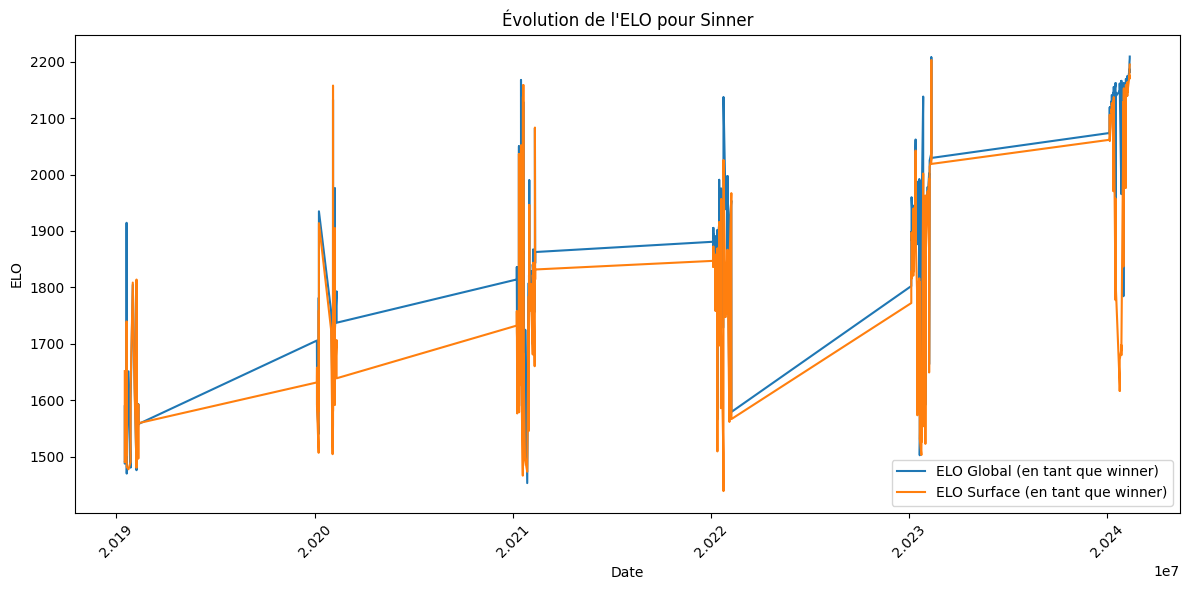

In [33]:
import matplotlib.pyplot as plt

# Exemple pour Sinner
player_name = 'Sinner'
player_df = df[df['winner_name'].str.contains(player_name, case=False) | df['loser_name'].str.contains(player_name, case=False)]
player_df = player_df.sort_values(by='tourney_date')

plt.figure(figsize=(12, 6))
plt.plot(player_df['tourney_date'], player_df['WINNER_ELO_BEFORE'], label='ELO Global (en tant que winner)')
plt.plot(player_df['tourney_date'], player_df['WINNER_ELO_SURFACE_BEFORE'], label='ELO Surface (en tant que winner)')
plt.title(f"Évolution de l'ELO pour {player_name}")
plt.xlabel("Date")
plt.ylabel("ELO")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

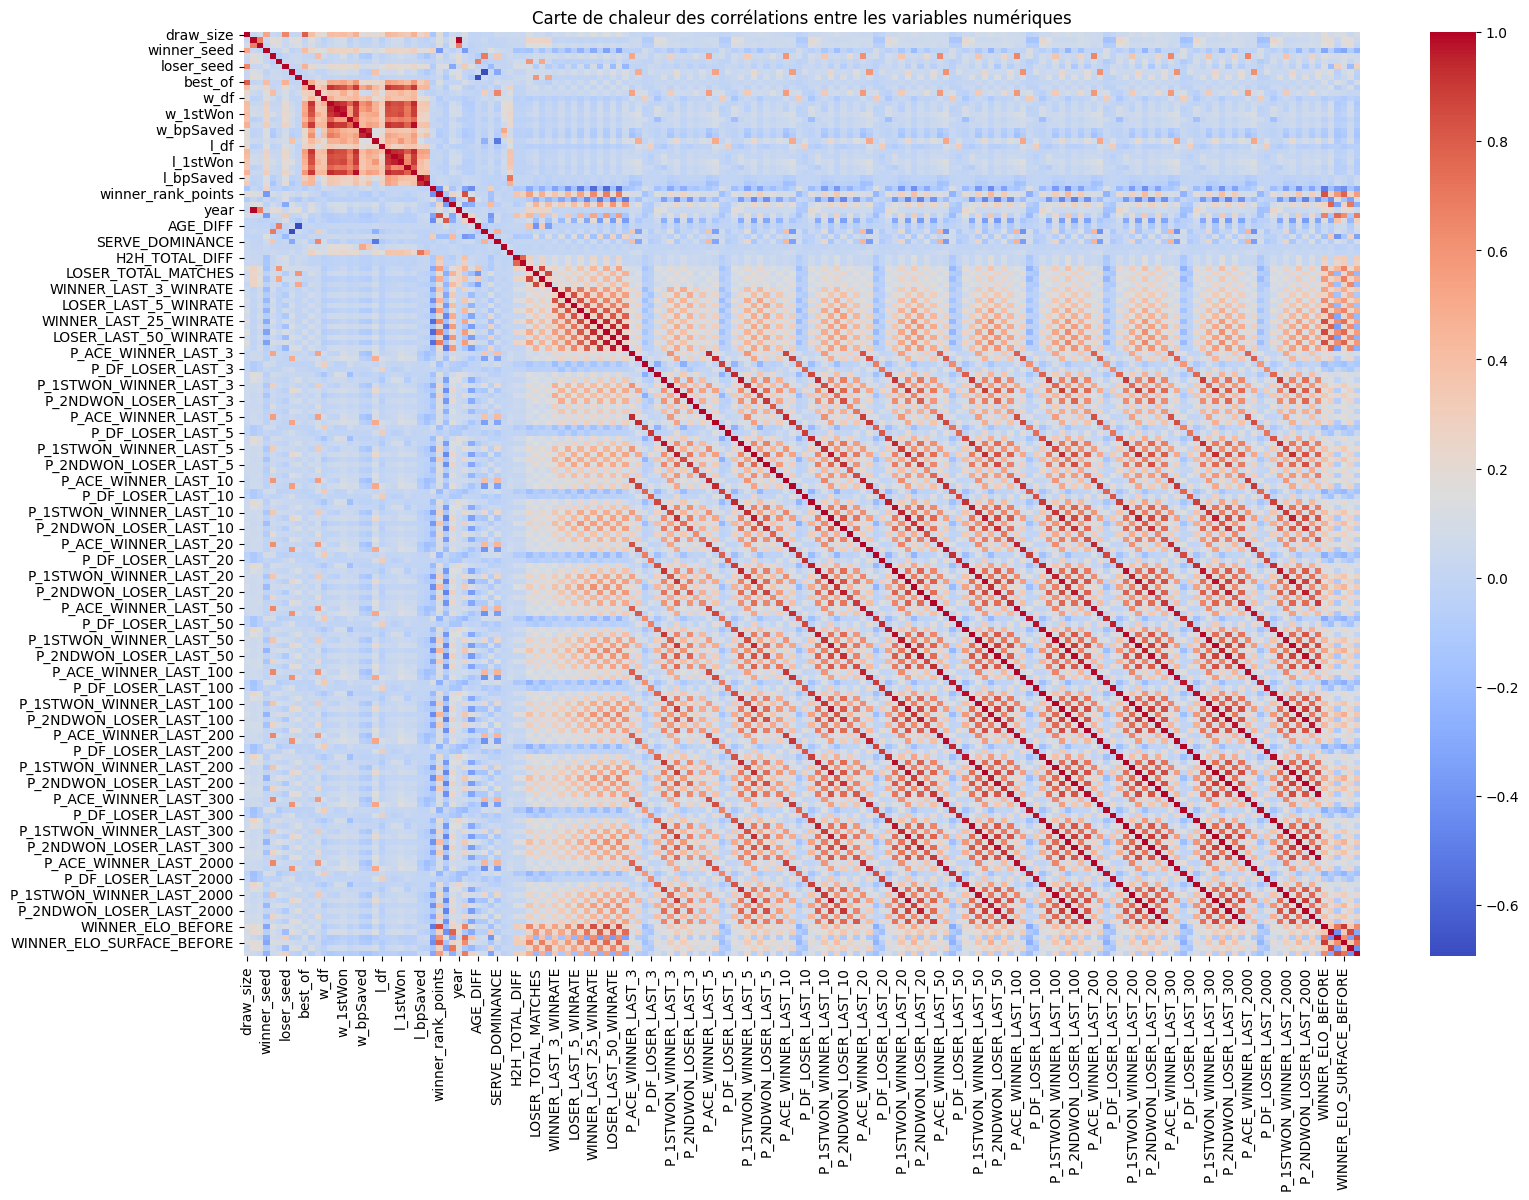

In [34]:
import seaborn as sns

# Garder que les colonnes numériques
numeric_cols = df.select_dtypes(include='number').drop(columns=['winner_id', 'loser_id']).copy()
corr = numeric_cols.corr()

plt.figure(figsize=(18, 12))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Carte de chaleur des corrélations entre les variables numériques")
plt.show()


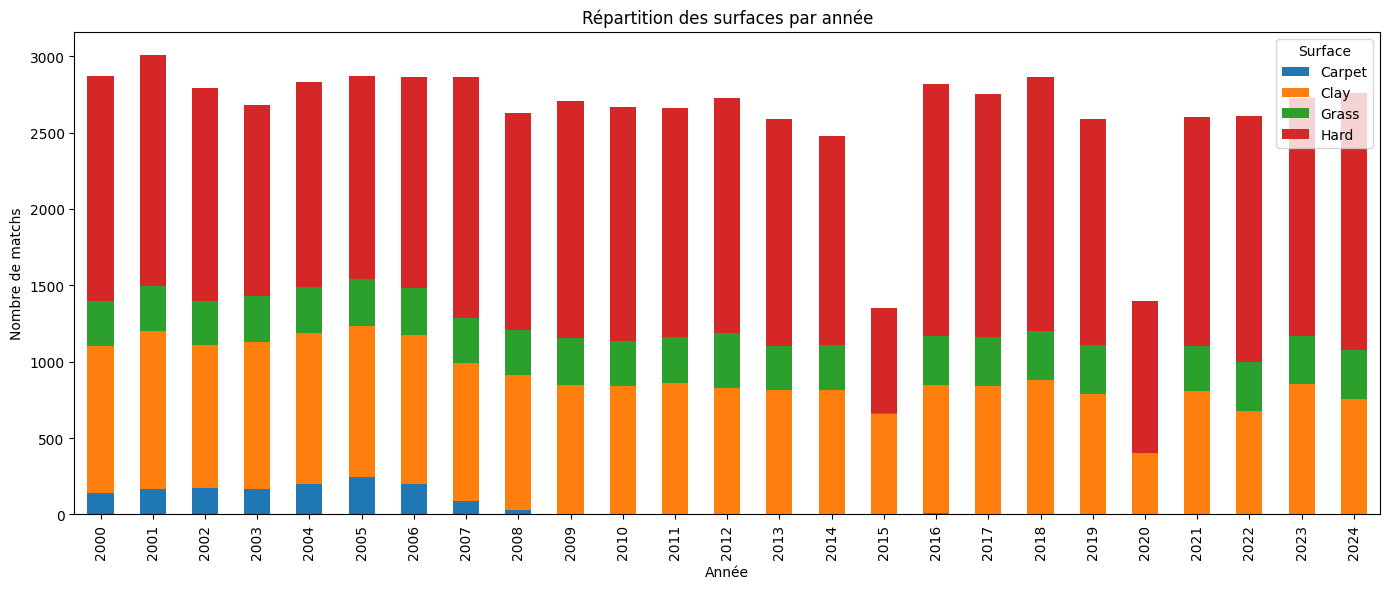

In [35]:
surface_by_year = df.groupby(['year', 'surface_raw']).size().unstack().fillna(0)

surface_by_year.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title("Répartition des surfaces par année")
plt.xlabel("Année")
plt.ylabel("Nombre de matchs")
plt.xticks(rotation=90)
plt.legend(title="Surface")
plt.tight_layout()
plt.show()

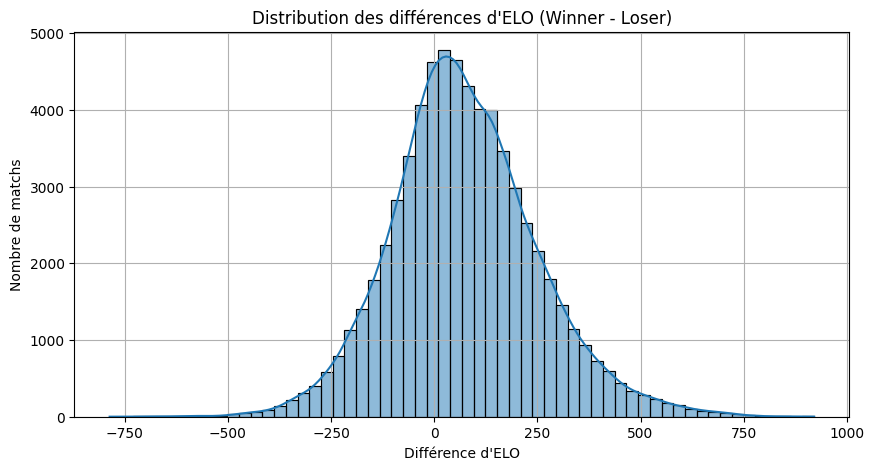

In [36]:
plt.figure(figsize=(10, 5))
sns.histplot(df['ELO_DIFF'], kde=True, bins=60)
plt.title("Distribution des différences d'ELO (Winner - Loser)")
plt.xlabel("Différence d'ELO")
plt.ylabel("Nombre de matchs")
plt.grid(True)
plt.show()


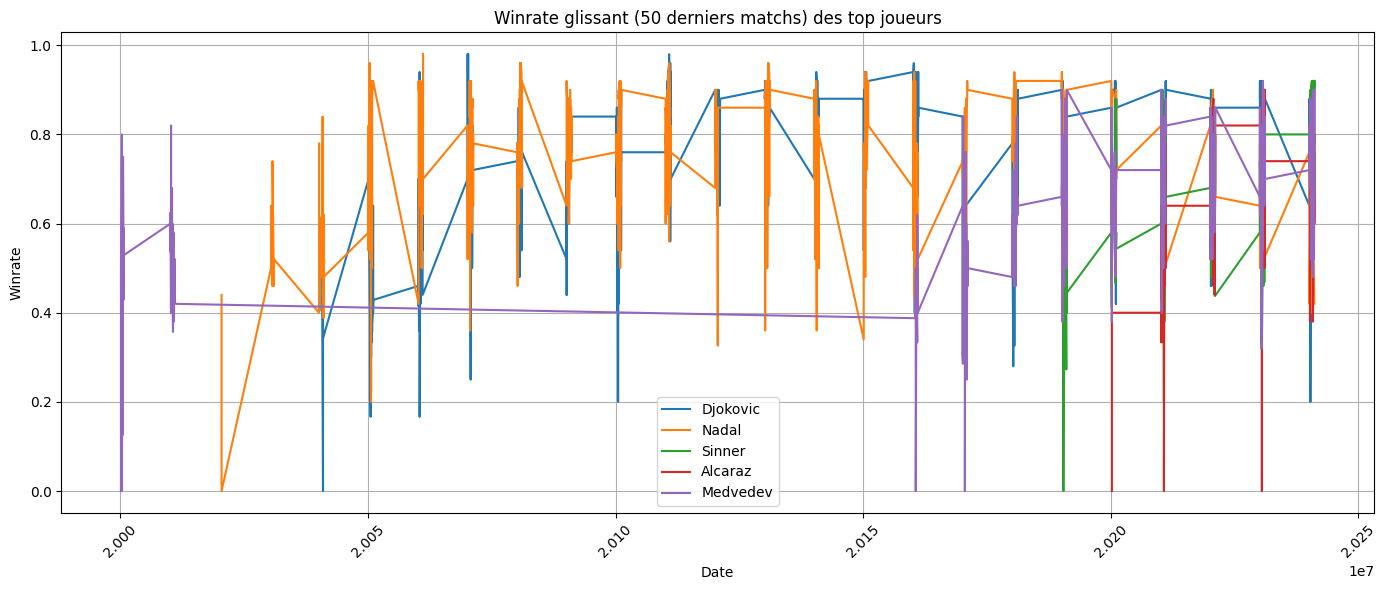

In [37]:
top_players = ['Djokovic', 'Nadal', 'Sinner', 'Alcaraz', 'Medvedev']
plt.figure(figsize=(14, 6))

for name in top_players:
    subset = df[df['winner_name'].str.contains(name, case=False) | df['loser_name'].str.contains(name, case=False)]
    subset = subset.sort_values(by='tourney_date')
    plt.plot(subset['tourney_date'], subset['WINNER_LAST_50_WINRATE'], label=name)

plt.title("Winrate glissant (50 derniers matchs) des top joueurs")
plt.xlabel("Date")
plt.ylabel("Winrate")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


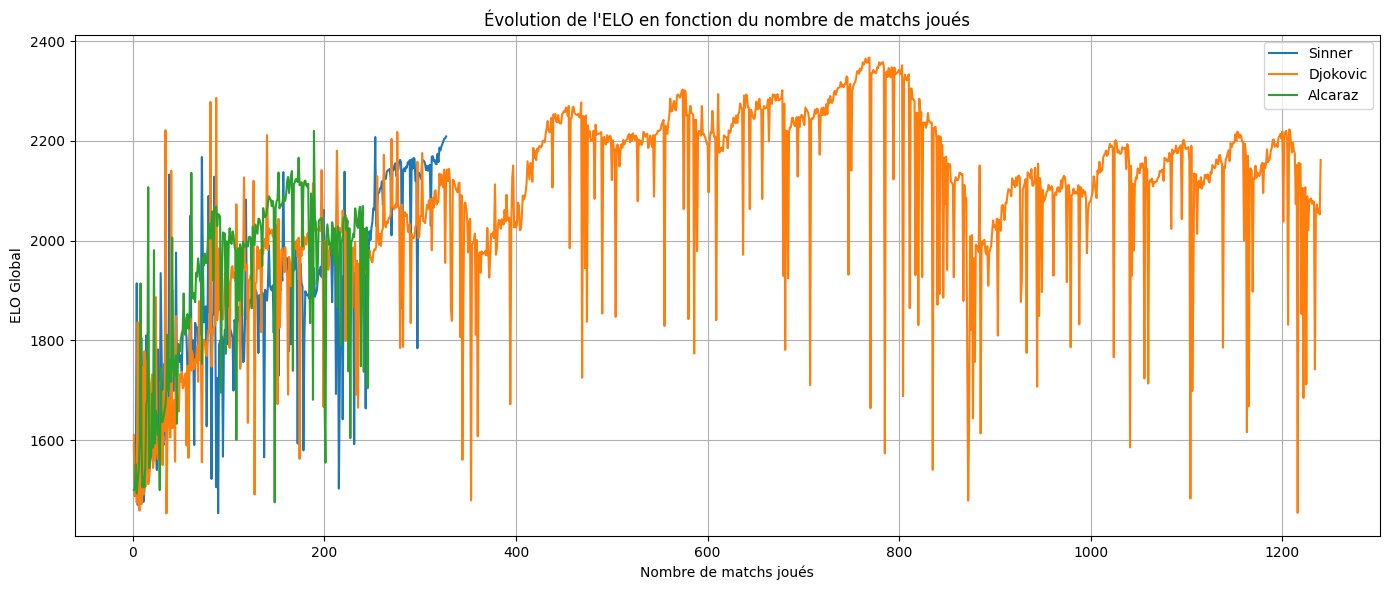

In [38]:
import matplotlib.pyplot as plt

# Choisir un ou plusieurs joueurs
players_to_plot = ['Sinner', 'Djokovic', 'Alcaraz']  # tu peux en ajouter autant que tu veux

plt.figure(figsize=(14, 6))

for name in players_to_plot:
    # Filtrer tous les matchs du joueur (winner ou loser)
    player_matches = df[(df['winner_name'].str.contains(name, case=False)) | 
                        (df['loser_name'].str.contains(name, case=False))].copy()
    
    # Trier par date pour simuler les matchs dans l'ordre chronologique
    player_matches = player_matches.sort_values(by='tourney_date').reset_index(drop=True)
    
    # Créer une colonne "match_count" (x-axis)
    player_matches['match_number'] = range(1, len(player_matches) + 1)
    
    # Tracer l'ELO global
    plt.plot(player_matches['match_number'], player_matches['WINNER_ELO_BEFORE'], label=name)

plt.title("Évolution de l'ELO en fonction du nombre de matchs joués")
plt.xlabel("Nombre de matchs joués")
plt.ylabel("ELO Global")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

Let's plot the ELO rating progression of Novak Djokovic

In [39]:
player = list(all_elo[103819])
player_grass = list(all_elo_surfaces["Grass"][103819])
player_clay = list(all_elo_surfaces["Clay"][103819])
player_hard = list(all_elo_surfaces["Hard"][103819])

# Create a simple line plot
fig = plt.figure(figsize=(8, 4))

plt.plot(player, marker='.', linewidth=0.5, markersize=1, linestyle='-', color='black', label="Overall")


plt.title("Roger Federer's Elo Rating Over Time")
plt.xlabel("Match Number")
plt.ylabel("Elo Rating")

plt.legend(loc="lower right")

plt.grid(True)
plt.savefig("./images/ROGER_FEDREDR_elo_rating.png", dpi=500)

plt.draw()
plt.show()


NameError: name 'all_elo' is not defined

In [ ]:
def plot_player_elo_graph(player_id, player_name):
    plt.close('all')

    player = list(all_elo[player_id])
    player_grass = list(all_elo_surfaces["Grass"][player_id])
    player_clay = list(all_elo_surfaces["Clay"][player_id])
    player_hard = list(all_elo_surfaces["Hard"][player_id])

    # Create a simple line plot
    fig = plt.figure(figsize=(8, 4))

    plt.plot(player_grass, marker='.', linewidth=0.5, markersize=1, linestyle='-', color='green', label="Grass")
    plt.plot(player_clay, marker='.', linewidth=0.5, markersize=1, linestyle='-', color='brown', label="Clay")
    plt.plot(player_hard, marker='.', linewidth=0.5, markersize=1, linestyle='-', color='#ADD8E6', label="Hard")
    plt.plot(player, marker='.', linewidth=0.5, markersize=1, linestyle='-', color='black', label="Overall")


    plt.title(player_name+"'s Elo Rating Over Time")
    plt.xlabel("Match Number")
    plt.ylabel("Elo Rating")

    plt.legend(loc="lower right")

    plt.grid(True)
    plt.savefig("./images/"+"".join(player_name.split())+"_elo_rating.png", dpi=500)

    plt.draw()
    plt.show()

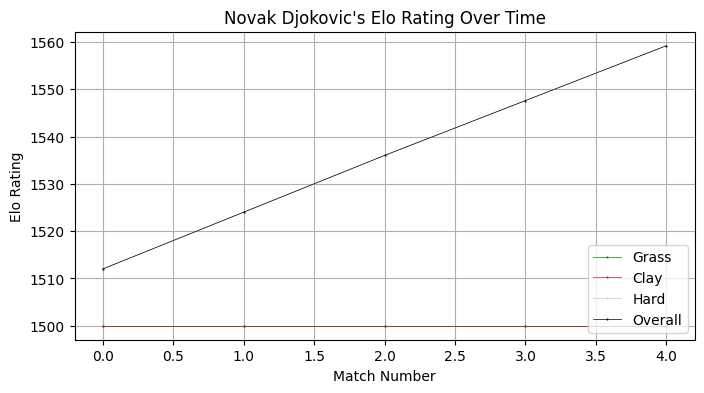

In [ ]:
plot_player_elo_graph(104925, "Novak Djokovic")

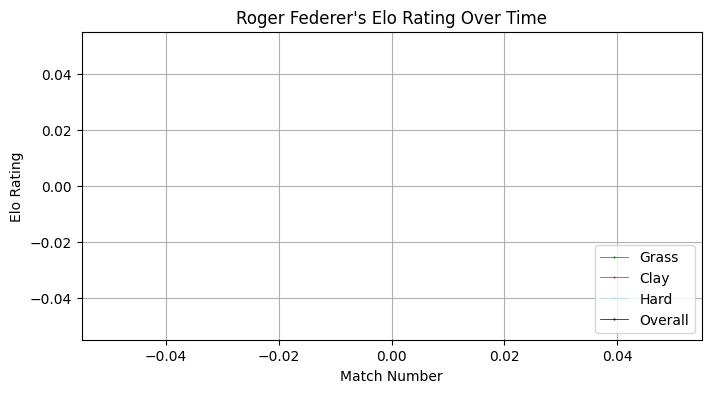

In [ ]:
plot_player_elo_graph(103819, "Roger Federer")

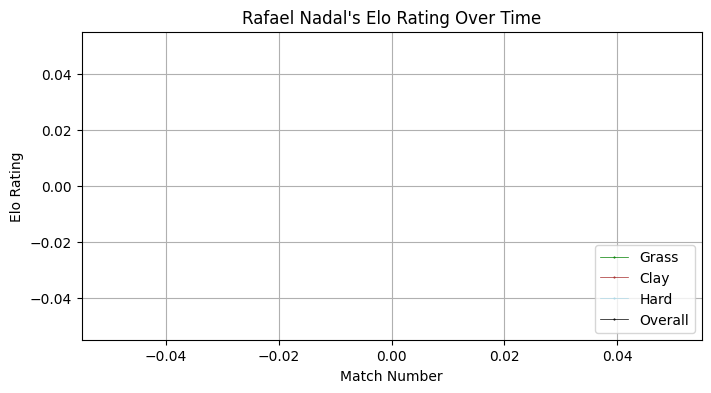

In [ ]:
plot_player_elo_graph(104745, "Rafael Nadal")

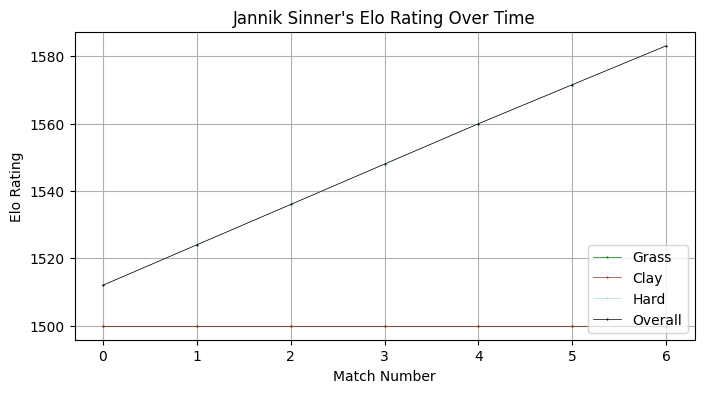

In [ ]:
plot_player_elo_graph(206173, "Jannik Sinner")

In [ ]:
player = list(all_elo[207989])
player[-1]

1524.400483725585

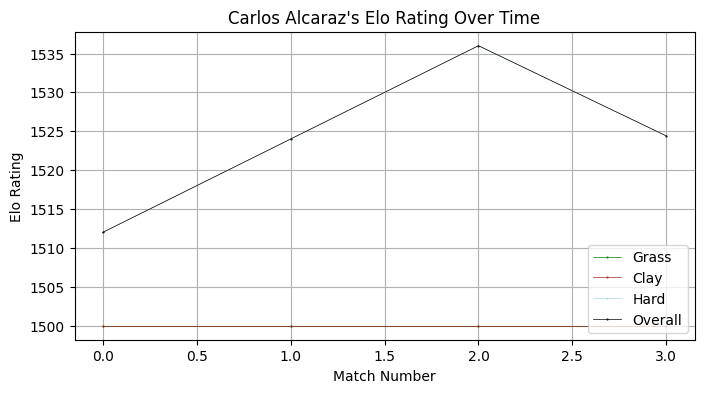

In [ ]:
plot_player_elo_graph(207989, "Carlos Alcaraz")

In [40]:
from IPython.display import display
plt.close('all')

nadal = list(all_elo[104745])
novak = list(all_elo[104925])
federer = list(all_elo[103819])
jiri = list(all_elo[208103])
jannik = list(all_elo[206173])
carlos = list(all_elo[207989])
gael = list(all_elo[104792])
nick = list(all_elo[106401])
andy = list(all_elo[104918])
pete = list(all_elo[101736])

# Create a simple line plot
fig = plt.figure(figsize=(8, 4))

for player in all_elo.keys():
    plt.plot(list(all_elo[player]), marker='.', linewidth=0.1, markersize=1, linestyle='-', color='black')

plt.plot(nadal, marker='.', linewidth=0.5, markersize=1, linestyle='-', color='blue', label="Rafa Nadal")
plt.plot(novak, marker='.', linewidth=0.5, markersize=1, linestyle='-', color='red', label="Novak Djokovic")
plt.plot(federer, marker='.', linewidth=0.5, markersize=1, linestyle='-', color='green', label="Roger Federer")
plt.plot(jiri, marker='.', linewidth=0.5, markersize=1, linestyle='-', color='purple', label="Jiri Lehecka")
plt.plot(jannik, marker='.', linewidth=0.5, markersize=1, linestyle='-', color='pink', label="Jannik Sinner")
plt.plot(carlos, marker='.', linewidth=0.5, markersize=1, linestyle='-', color='yellow', label="Carlos Alcaraz")
plt.plot(gael, marker='.', linewidth=0.5, markersize=1, linestyle='-', color='gray', label="Gael Monfils")
plt.plot(nick, marker='.', linewidth=0.5, markersize=1, linestyle='-', color='gold', label="Nick Kyrgios")
plt.plot(nick, marker='.', linewidth=0.5, markersize=1, linestyle='-', color='brown', label="Andy Murray")
plt.plot(pete, marker='.', linewidth=0.5, markersize=1, linestyle='-', color='silver', label="Pete Sampras")

plt.title("Elo Ratings Over Time")
plt.xlabel("Match Number")
plt.ylabel("Elo Rating")

plt.legend(loc="lower right")

plt.grid(True)
plt.savefig("./images/elo_ratings_plot.png", dpi=500)

plt.draw()
plt.show()


NameError: name 'all_elo' is not defined

### Final tweaks on the dataset

#### Randomize Dataset

In [32]:
final_data["RESULT"] = 1

In [33]:
column_to_randomize = []

for val in list(final_data.columns):
    if "DIFF" in val:
        print(val)
        column_to_randomize.append(val)

column_to_randomize.append("RESULT")
column_to_randomize.append("WINNER_ID")
column_to_randomize.append("LOSER_ID")

final_data[column_to_randomize] = final_data[column_to_randomize].apply(lambda row: row * (-1) if np.random.rand() < 0.5 else row, axis=1)

ATP_POINT_DIFF
ATP_RANK_DIFF
AGE_DIFF
HEIGHT_DIFF
H2H_DIFF
H2H_SURFACE_DIFF
DIFF_N_GAMES
WIN_LAST_3_DIFF
WIN_LAST_5_DIFF
WIN_LAST_10_DIFF
WIN_LAST_25_DIFF
WIN_LAST_50_DIFF
WIN_LAST_100_DIFF
P_ACE_LAST_3_DIFF
P_DF_LAST_3_DIFF
P_1ST_IN_LAST_3_DIFF
P_1ST_WON_LAST_3_DIFF
P_2ND_WON_LAST_3_DIFF
P_BP_SAVED_LAST_3_DIFF
P_ACE_LAST_5_DIFF
P_DF_LAST_5_DIFF
P_1ST_IN_LAST_5_DIFF
P_1ST_WON_LAST_5_DIFF
P_2ND_WON_LAST_5_DIFF
P_BP_SAVED_LAST_5_DIFF
P_ACE_LAST_10_DIFF
P_DF_LAST_10_DIFF
P_1ST_IN_LAST_10_DIFF
P_1ST_WON_LAST_10_DIFF
P_2ND_WON_LAST_10_DIFF
P_BP_SAVED_LAST_10_DIFF
P_ACE_LAST_20_DIFF
P_DF_LAST_20_DIFF
P_1ST_IN_LAST_20_DIFF
P_1ST_WON_LAST_20_DIFF
P_2ND_WON_LAST_20_DIFF
P_BP_SAVED_LAST_20_DIFF
P_ACE_LAST_50_DIFF
P_DF_LAST_50_DIFF
P_1ST_IN_LAST_50_DIFF
P_1ST_WON_LAST_50_DIFF
P_2ND_WON_LAST_50_DIFF
P_BP_SAVED_LAST_50_DIFF
P_ACE_LAST_100_DIFF
P_DF_LAST_100_DIFF
P_1ST_IN_LAST_100_DIFF
P_1ST_WON_LAST_100_DIFF
P_2ND_WON_LAST_100_DIFF
P_BP_SAVED_LAST_100_DIFF
P_ACE_LAST_200_DIFF
P_DF_LAST_200_DIFF
P_1

In [34]:
def fix_ids(row):
    winner, loser = row['WINNER_ID'], row['LOSER_ID']
    if winner < 0 and loser < 0:
        winner, loser = abs(loser), abs(winner)  # Swap and remove negative signs
    return pd.Series([winner, loser])

# Apply transformation
final_data[['WINNER_ID', 'LOSER_ID']] = final_data.apply(fix_ids, axis=1)
final_data.rename(columns={'WINNER_ID': 'PLAYER_1', 'LOSER_ID': 'PLAYER_2'}, inplace=True)

## Plot Datset

In [35]:
final_data

PLAYER_1  PLAYER_2  ATP_POINT_DIFF  ATP_RANK_DIFF   AGE_DIFF  \
0    101746.0  101142.0         -1028.0           69.0  -5.000000   
1    100587.0  101613.0          -257.0          126.0  10.300000   
2    101601.0  101179.0          -352.0          135.0  -3.700000   
3    101117.0  101332.0            19.0           -7.0   2.000000   
4    101901.0  101735.0          -734.0          162.0  -0.900000   
..        ...       ...             ...            ...        ...   
111  207989.0  104925.0          3110.0           -4.0 -15.953457   
112  210097.0  132283.0          1254.0          -35.0  -7.413415   
113  200282.0  206173.0         -8295.0            7.0   2.493498   
114  210097.0  206173.0         -9550.0           19.0  -1.147844   
115  206173.0  100644.0          4195.0           -1.0  -4.323066   

     HEIGHT_DIFF  BEST_OF  DRAW_SIZE  H2H_DIFF  H2H_SURFACE_DIFF  ...  \
0           -5.0        3         32      -0.0              -0.0  ...   
1            8.0        3         32      -0.0              -0.0  ...   
2           -0.0        3         32      -0.0              -0.0  ...   
3            7.0        3         32       0.0               0.0  ...   
4          -11.0        3         32       0.0               0.0  ...   
..           ...      ...        ...       ...               ...  ...   
111         -5.0        5        128      -0.0              -0.0  ...   
112          2.0        5        128       0.0               0.0  ...   
113         -8.0        5        128      -0.0              -0.0  ...   
114          2.0        5        128      -0.0              -0.0  ...   
115         -7.0        5        128       0.0               0.0  ...   

      ELO_DIFF  ELO_SURFACE_DIFF  ELO_GRAD_5_DIFF  ELO_GRAD_10_DIFF  \
0   -24.000000        -24.000000        -0.000000              -0.0   
1   -24.000000        -24.000000        -0.000000              -0.0   
2   -24.000000        -24.000000        -0.000000              -0.0   
3    24.000000         24.000000         0.000000               0.0   
4    24.000000         24.000000         0.000000               0.0   
..         ...               ...              ...               ...   
111 -34.798532        -34.798532        -0.000000              -0.0   
112  12.828601         12.828601         0.000000               0.0   
113 -24.372361        -24.372361        -0.000000              -0.0   
114 -34.772822        -34.772822        -0.000000              -0.0   
115  35.865671         35.865671         0.225004               0.0   

     ELO_GRAD_20_DIFF  ELO_GRAD_35_DIFF  ELO_GRAD_50_DIFF  ELO_GRAD_100_DIFF  \
0                -0.0              -0.0              -0.0               -0.0   
1                -0.0              -0.0              -0.0               -0.0   
2                -0.0              -0.0              -0.0               -0.0   
3                 0.0               0.0               0.0                0.0   
4                 0.0               0.0               0.0                0.0   
..                ...               ...               ...                ...   
111              -0.0              -0.0              -0.0               -0.0   
112               0.0               0.0               0.0                0.0   
113              -0.0              -0.0              -0.0               -0.0   
114              -0.0              -0.0              -0.0               -0.0   
115               0.0               0.0               0.0                0.0   

     ELO_GRAD_250_DIFF  RESULT  
0                 -0.0    -1.0  
1                 -0.0    -1.0  
2                 -0.0    -1.0  
3                  0.0     1.0  
4                  0.0     1.0  
..                 ...     ...  
111               -0.0    -1.0  
112                0.0     1.0  
113               -0.0    -1.0  
114               -0.0    -1.0  
115                0.0     1.0  

[3158 rows x 81 columns]

In [36]:
# sns.pairplot(final_data, hue='RESULT')

![image info](./images/outputAllFeatures.png)

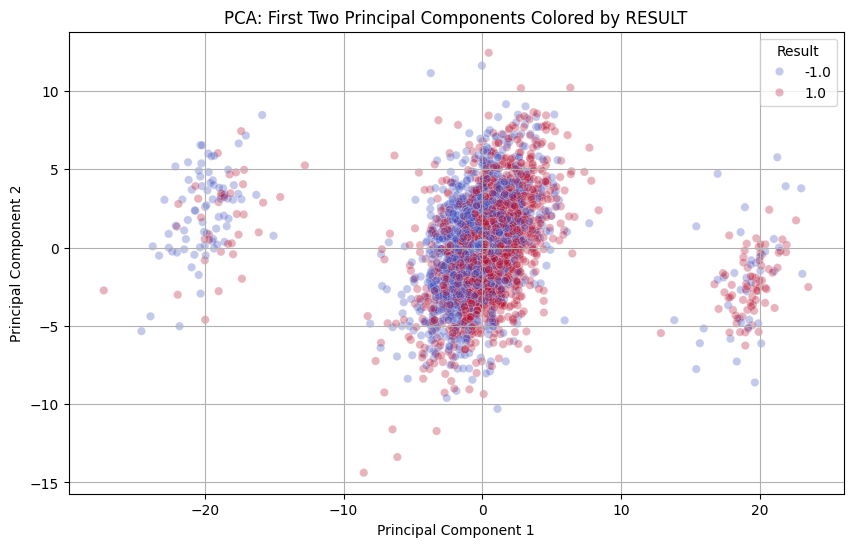

In [37]:
# Drop the target variable ('RESULT') if it exists
features = final_data.drop(columns=['RESULT'], errors='ignore')

# Standardizing the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Applying PCA with 9 principal components
pca_9 = PCA(n_components=9)
principal_components_9 = pca_9.fit_transform(features_scaled)

# Creating a DataFrame with the first 9 principal components
pca_df_9 = pd.DataFrame(principal_components_9, columns=[f'PC{i+1}' for i in range(9)])

# Add the RESULT column back to the PCA DataFrame (if it was originally present in the dataset)
pca_df_9['RESULT'] = final_data['RESULT'].values

# Plot the first two principal components with hue set to RESULT
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_df_9['PC1'], y=pca_df_9['PC2'], hue=pca_df_9['RESULT'], palette='coolwarm', alpha=0.3)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First Two Principal Components Colored by RESULT')
plt.legend(title="Result")
plt.grid(True)
plt.show()


In [38]:
pca_df_9

PC1       PC2       PC3       PC4       PC5        PC6       PC7  \
0    -0.097271  0.010544 -0.365368 -0.182637  0.261405  -0.423424 -0.919032   
1    -0.055030  0.304883 -0.258702 -0.169530  0.183271  -0.653281 -0.701773   
2    -0.097897  0.116889 -0.281575 -0.161246  0.240102  -0.512194 -0.794372   
3     0.064663  0.160398  0.165522  0.077013 -0.052413  -0.832514 -0.009088   
4    -0.108403 -0.083909 -0.156057  0.120315  0.199585  -0.508276 -0.682982   
...        ...       ...       ...       ...       ...        ...       ...   
3153  0.059010 -0.099201  0.201281  0.087755  0.020661   4.998604  2.292610   
3154  0.093863  0.019652  0.295836  0.153072  0.101364   6.022370  2.420745   
3155 -0.273292  0.034253 -1.251464 -0.677949  1.308975   9.661217 -0.449552   
3156 -0.304844  0.213801 -1.384603 -0.902001  1.495402  10.212732 -0.803511   
3157  0.169049 -0.162833  0.719271  0.574216 -0.298342   4.397625  3.111548   

           PC8       PC9  RESULT  
0    -0.009256  0.080380    -1.0  
1     0.158739  0.206204    -1.0  
2     0.062211  0.084004    -1.0  
3     0.077802  0.076646     1.0  
4     0.032396  0.164651     1.0  
...        ...       ...     ...  
3153 -0.463883 -0.342070    -1.0  
3154 -0.373001 -0.168782     1.0  
3155 -0.322029  0.390181    -1.0  
3156 -0.221940  0.401737    -1.0  
3157 -0.418306 -0.252732     1.0  

[3158 rows x 10 columns]

In [39]:
# sns.pairplot(data=pca_df_9, hue="RESULT")

![image info](./images/outputPCA_Pariplot2.png)

In [40]:
if 'ELO_DIFF' in final_data.columns:
    pca_df_9['ELO_DIFF'] = final_data['ELO_DIFF'].values

if 'DIFF_N_GAMES' in final_data.columns:
    pca_df_9['DIFF_N_GAMES'] = final_data['DIFF_N_GAMES'].values

if 'H2H_DIFF' in final_data.columns:
    pca_df_9['H2H_DIFF'] = final_data['H2H_DIFF'].values

if 'P_1ST_WON_LAST_50_DIFF' in final_data.columns:
    pca_df_9['P_1ST_WON_LAST_50_DIFF'] = final_data['P_1ST_WON_LAST_50_DIFF'].values


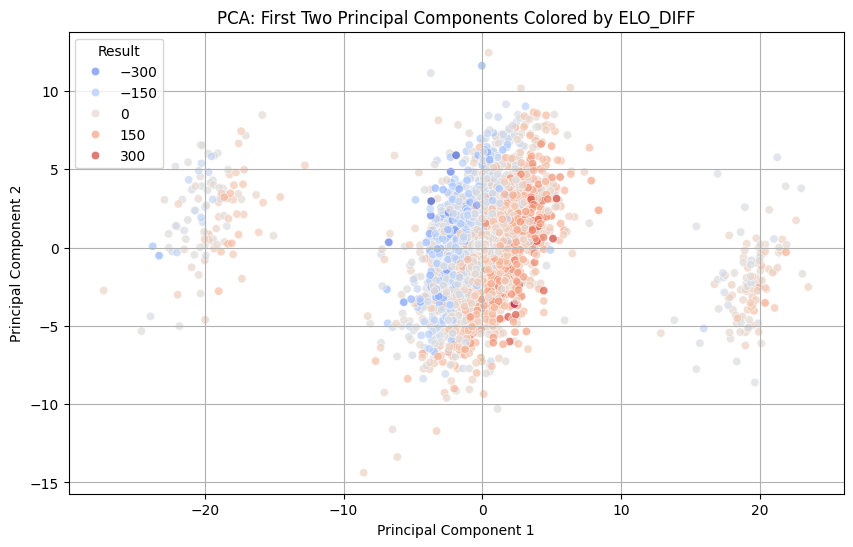

In [41]:
# P_1ST_WON_LAST_50_DIFF
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_df_9['PC1'], y=pca_df_9['PC2'], hue=pca_df_9['ELO_DIFF'], palette='coolwarm', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First Two Principal Components Colored by ELO_DIFF')
plt.legend(title="Result")
plt.grid(True)
plt.show()

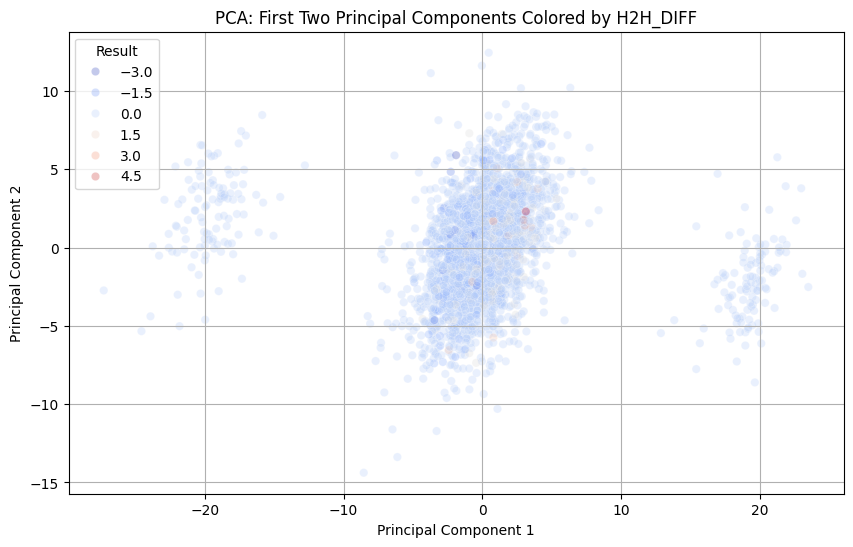

In [42]:
# P_1ST_WON_LAST_50_DIFF
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_df_9['PC1'], y=pca_df_9['PC2'], hue=pca_df_9['H2H_DIFF'], palette='coolwarm', alpha=0.3)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First Two Principal Components Colored by H2H_DIFF')
plt.legend(title="Result")
plt.grid(True)
plt.show()

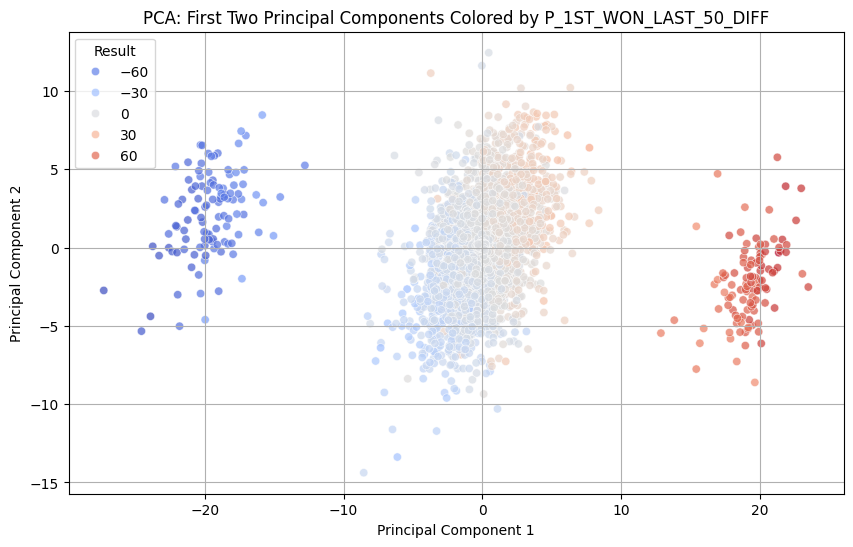

In [43]:
# P_1ST_WON_LAST_50_DIFF
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_df_9['PC1'], y=pca_df_9['PC2'], hue=pca_df_9['P_1ST_WON_LAST_50_DIFF'], palette='coolwarm', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First Two Principal Components Colored by P_1ST_WON_LAST_50_DIFF')
plt.legend(title="Result")
plt.grid(True)
plt.show()

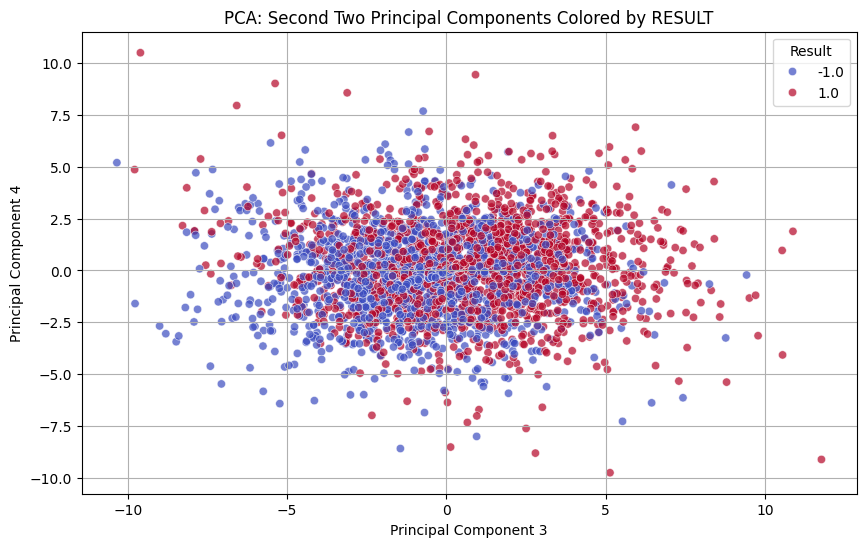

In [44]:
# Plot the first two principal components with hue set to RESULT
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_df_9['PC3'], y=pca_df_9['PC4'], hue=pca_df_9['RESULT'], palette='coolwarm', alpha=0.7)
plt.xlabel('Principal Component 3')
plt.ylabel('Principal Component 4')
plt.title('PCA: Second Two Principal Components Colored by RESULT')
plt.legend(title="Result")
plt.grid(True)
plt.show()


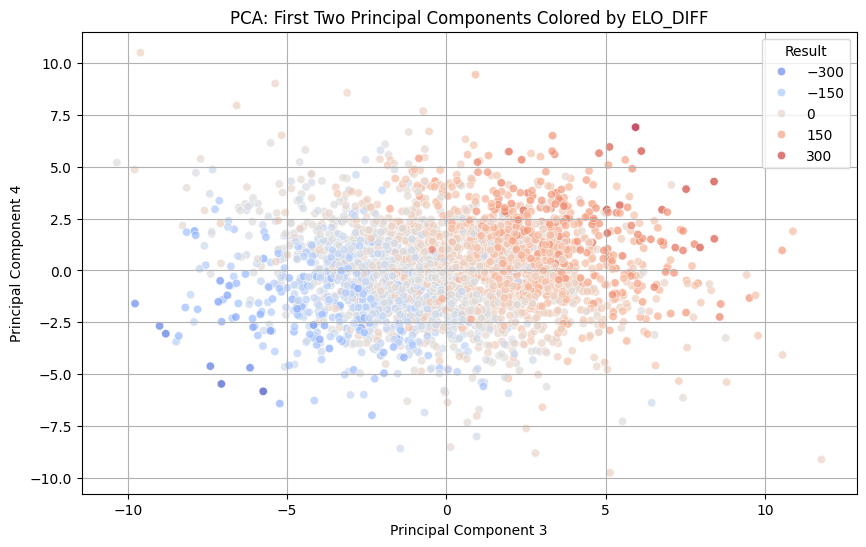

In [45]:
# Plot the first two principal components with hue set to RESULT
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_df_9['PC3'], y=pca_df_9['PC4'], hue=pca_df_9['ELO_DIFF'], palette='coolwarm', alpha=0.7)
plt.xlabel('Principal Component 3')
plt.ylabel('Principal Component 4')
plt.title('PCA: First Two Principal Components Colored by ELO_DIFF')
plt.legend(title="Result")
plt.grid(True)
plt.show()


In [46]:
# Get PCA loadings (how much each original feature contributes to each principal component)
loadings = pd.DataFrame(pca_9.components_.T, 
                        columns=[f'PC{i+1}' for i in range(9)], 
                        index=features.columns)

# Display absolute contributions of features to PC1 & PC2
print("Feature importance in PC1 and PC2:")
print(loadings[['PC1', 'PC2', 'PC3', 'PC4']].abs().sort_values(by='PC1', ascending=False))


Feature importance in PC1 and PC2:
                               PC1       PC2       PC3       PC4
P_1ST_WON_LAST_20_DIFF    0.172890  0.020293  0.001189  0.022630
P_1ST_WON_LAST_300_DIFF   0.172857  0.020403  0.002445  0.024274
P_1ST_WON_LAST_200_DIFF   0.172857  0.020403  0.002445  0.024274
P_1ST_WON_LAST_100_DIFF   0.172857  0.020403  0.002445  0.024274
P_1ST_WON_LAST_2000_DIFF  0.172857  0.020403  0.002445  0.024274
...                            ...       ...       ...       ...
DRAW_SIZE                 0.002148  0.002220  0.013358  0.009886
PLAYER_1                  0.000162  0.000038  0.002081  0.002185
PLAYER_2                  0.000067  0.001471  0.003806  0.002834
ELO_GRAD_250_DIFF         0.000000  0.000000  0.000000  0.000000
ELO_GRAD_100_DIFF         0.000000  0.000000  0.000000  0.000000

[80 rows x 4 columns]


## Final Dataset

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [109]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Création des labels
df_original = df.copy()
df_original['TARGET'] = 1

# Inversion des rôles winner/loser
df_inv = df.copy()
df_inv['TARGET'] = 0

# Colonnes à inverser
swap_cols = {
    'winner_id': 'loser_id', 'loser_id': 'winner_id',
    'winner_name': 'loser_name', 'loser_name': 'winner_name',
    'WINNER_ELO_BEFORE': 'LOSER_ELO_BEFORE', 'LOSER_ELO_BEFORE': 'WINNER_ELO_BEFORE',
    'WINNER_ELO_SURFACE_BEFORE': 'LOSER_ELO_SURFACE_BEFORE', 'LOSER_ELO_SURFACE_BEFORE': 'WINNER_ELO_SURFACE_BEFORE',
    'WINNER_TOTAL_MATCHES': 'LOSER_TOTAL_MATCHES', 'LOSER_TOTAL_MATCHES': 'WINNER_TOTAL_MATCHES',
    'WINNER_SURFACE_MATCHES': 'LOSER_SURFACE_MATCHES', 'LOSER_SURFACE_MATCHES': 'WINNER_SURFACE_MATCHES'
}

# Ajouter les colonnes dynamiques comme WINNER_LAST_X
for col in df.columns:
    if 'WINNER' in col and col.replace('WINNER', 'LOSER') in df.columns:
        swap_cols[col] = col.replace('WINNER', 'LOSER')
    elif 'LOSER' in col and col.replace('LOSER', 'WINNER') in df.columns:
        swap_cols[col] = col.replace('LOSER', 'WINNER')

# Renommer les colonnes inversées
df_inv = df_inv.rename(columns=swap_cols)

# Fusionner les deux
df_model = pd.concat([df_original, df_inv], ignore_index=True)


### Decision Tree with Sklearn

In [110]:
# Exclusion de colonnes non numériques ou identifiants
exclude_cols = ['tourney_id', 'tourney_name', 'round', 'score', 'winner_name', 'loser_name', 'surface_raw']
feature_cols = [col for col in df_model.columns if col not in exclude_cols and df_model[col].dtype != 'object' and col != 'TARGET']

X = df_model[feature_cols]
y = df_model['TARGET']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [111]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Entraînement du modèle
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = clf.predict(X_test)
# Prédiction sur les données d'entraînement pour mesurer la training accuracy
y_train_pred = clf.predict(X_train)

# Affichage des résultats
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Training Accuracy: 0.9329586091455527
Test Accuracy: 0.9228867077531766

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.92     13143
           1       0.90      0.95      0.92     13143

    accuracy                           0.92     26286
   macro avg       0.92      0.92      0.92     26286
weighted avg       0.92      0.92      0.92     26286



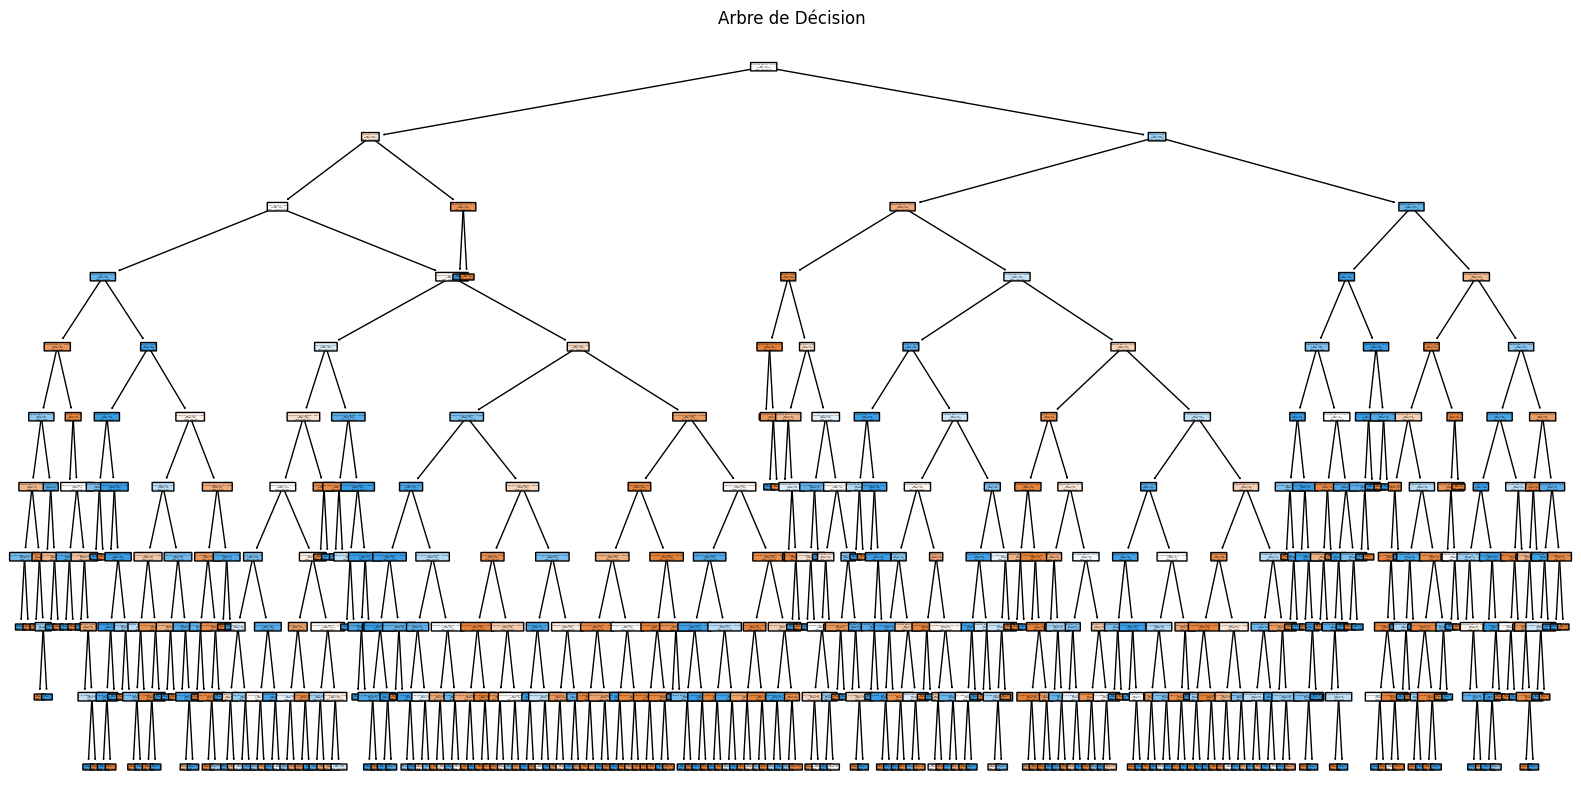

In [112]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=feature_cols, class_names=['Loss', 'Win'], filled=True, rounded=True)
plt.title("Arbre de Décision")
plt.show()


/home/cytech/miniconda3/envs/TFM_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


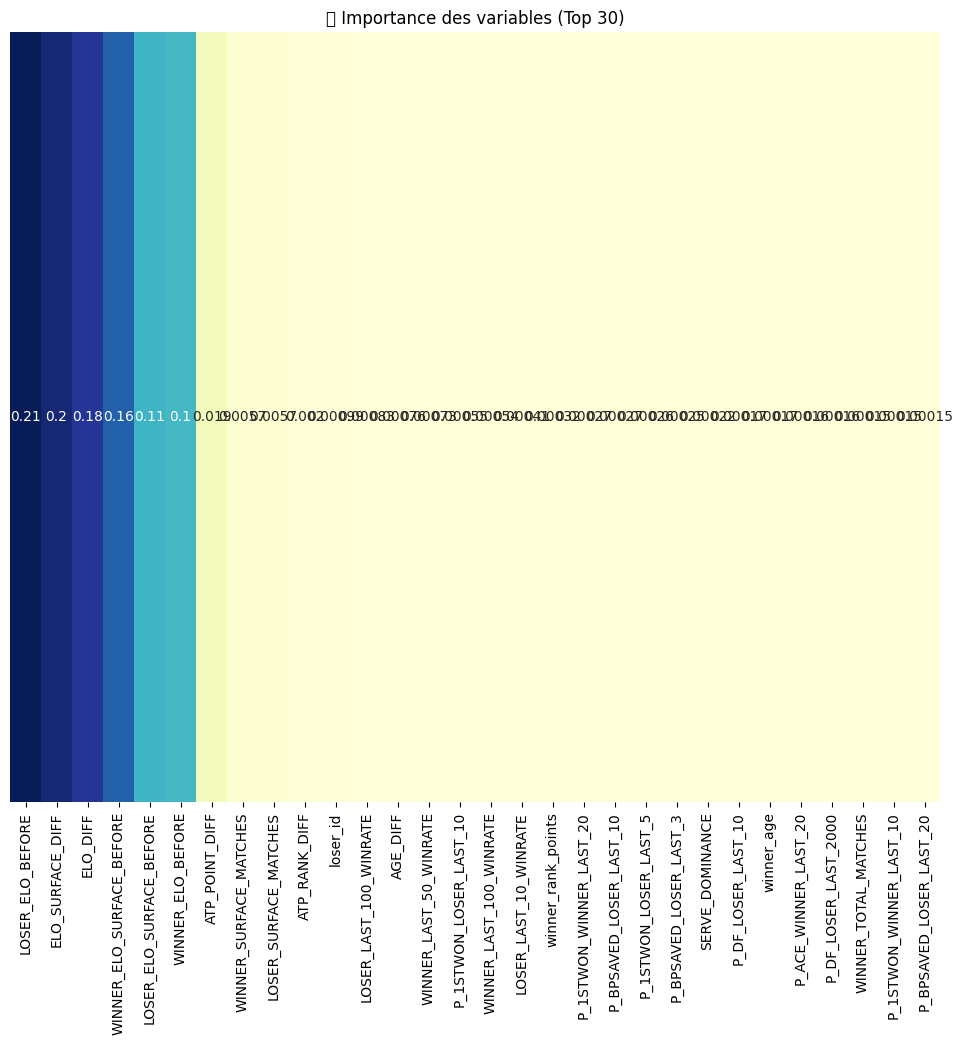

In [113]:
import seaborn as sns

# Importance des features
importances = pd.Series(clf.feature_importances_, index=feature_cols)
importances = importances.sort_values(ascending=False)[:30]  # top 30

plt.figure(figsize=(12, 10))
sns.heatmap(importances.to_frame().T, cmap="YlGnBu", annot=True, cbar=False)
plt.title("🔥 Importance des variables (Top 30)")
plt.yticks([])
plt.show()

In [114]:
top_feats = importances[importances > 0]
print("Top features utilisées dans l’arbre :")
print(top_feats)

Top features utilisées dans l’arbre :
LOSER_ELO_BEFORE             0.209910
ELO_SURFACE_DIFF             0.197174
ELO_DIFF                     0.182769
WINNER_ELO_SURFACE_BEFORE    0.156477
LOSER_ELO_SURFACE_BEFORE     0.106330
WINNER_ELO_BEFORE            0.102830
ATP_POINT_DIFF               0.019431
WINNER_SURFACE_MATCHES       0.005693
LOSER_SURFACE_MATCHES        0.005673
ATP_RANK_DIFF                0.002031
loser_id                     0.000989
LOSER_LAST_100_WINRATE       0.000830
AGE_DIFF                     0.000762
WINNER_LAST_50_WINRATE       0.000728
P_1STWON_LOSER_LAST_10       0.000550
WINNER_LAST_100_WINRATE      0.000537
LOSER_LAST_10_WINRATE        0.000405
winner_rank_points           0.000320
P_1STWON_WINNER_LAST_20      0.000268
P_BPSAVED_LOSER_LAST_10      0.000266
P_1STWON_LOSER_LAST_5        0.000261
P_BPSAVED_LOSER_LAST_3       0.000253
SERVE_DOMINANCE              0.000223
P_DF_LOSER_LAST_10           0.000168
winner_age                   0.000168
P_ACE_WINNER

## Random forest

In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd

# Sélection des colonnes numériques uniquement
X = df.select_dtypes(include='float64').copy()

# Cible binaire : 1 si winner_id < loser_id, 0 sinon (exemple arbitraire)
y = (df['winner_id'] < df['loser_id']).astype(int)

# Split train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Modèle Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Prédictions
y_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)

# Scores
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Features les plus importantes
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)
print("\nTop 15 features utilisées :\n", top_features)

Training Accuracy: 0.9823298280678644
Test Accuracy: 0.9784192566632851

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     11065
           1       0.98      0.98      0.98     10621

    accuracy                           0.98     21686
   macro avg       0.98      0.98      0.98     21686
weighted avg       0.98      0.98      0.98     21686


Top 15 features utilisées :
 AGE_DIFF                      0.553459
winner_age                    0.156154
loser_age                     0.146447
P_BPSAVED_LOSER_LAST_300      0.003580
ELO_SURFACE_DIFF              0.003146
P_BPSAVED_LOSER_LAST_2000     0.002898
P_2NDWON_WINNER_LAST_2000     0.002867
P_BPSAVED_LOSER_LAST_200      0.002851
P_2NDWON_WINNER_LAST_300      0.002536
P_BPSAVED_WINNER_LAST_2000    0.002496
P_BPSAVED_WINNER_LAST_200     0.002399
P_1STWON_WINNER_LAST_300      0.002273
LOSER_LAST_100_WINRATE        0.002114
LOSER_LAST_50_WINRATE         0.002049


In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tri des importances
importances = pd.Series(clf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Top 20 Features Importantes - Random Forest")
plt.tight_layout()
plt.show()


ValueError: Length of values (179) does not match length of index (163)

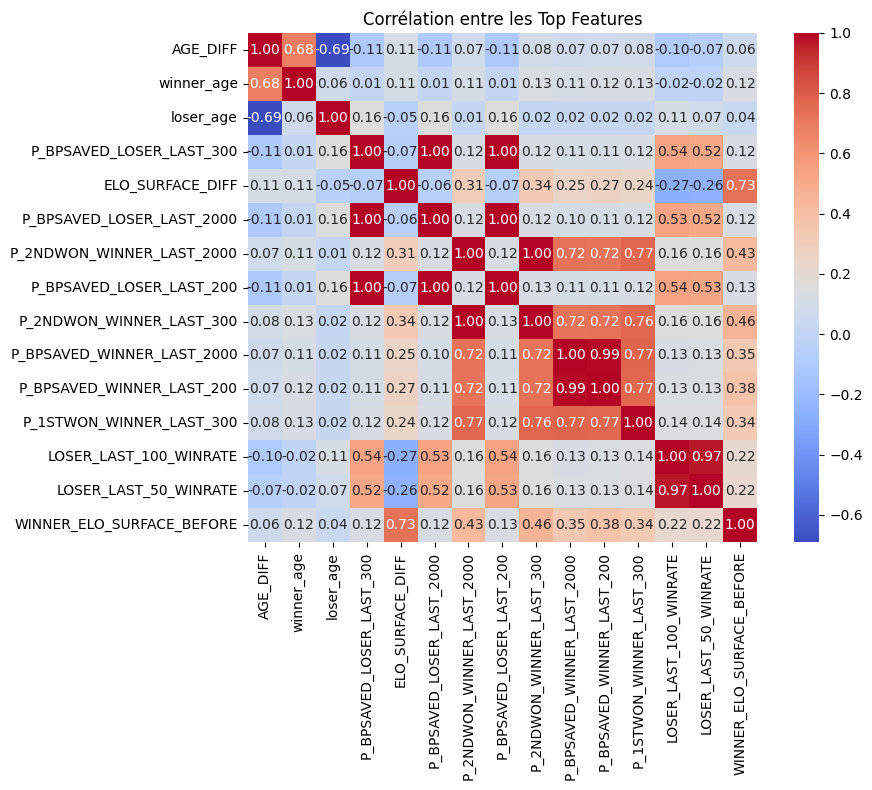

In [121]:
# Sélection des colonnes top_features
top_cols = top_features.index.tolist()
corr_top = df[top_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_top, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Corrélation entre les Top Features")
plt.tight_layout()
plt.show()

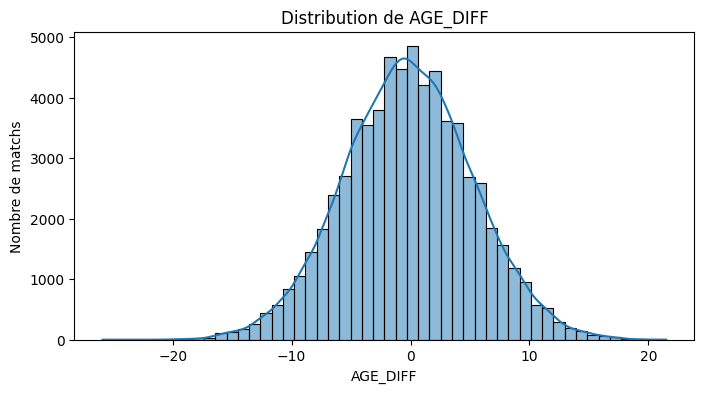

In [122]:
plt.figure(figsize=(8, 4))
sns.histplot(df["AGE_DIFF"], bins=50, kde=True)
plt.title("Distribution de AGE_DIFF")
plt.xlabel("AGE_DIFF")
plt.ylabel("Nombre de matchs")
plt.show()

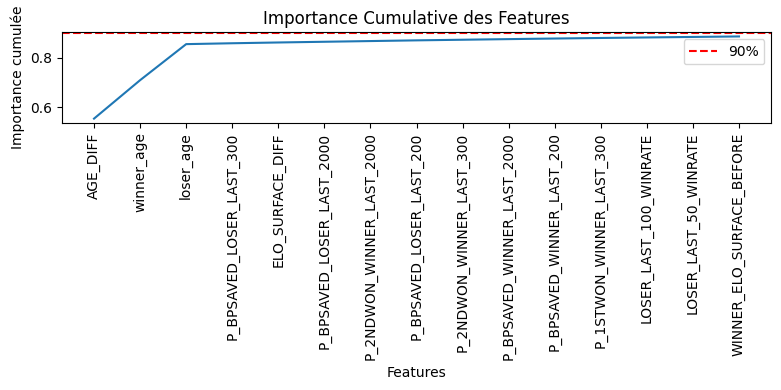

In [123]:
sorted_importances = top_features.sort_values(ascending=False)
cumulative_importance = sorted_importances.cumsum()

plt.figure(figsize=(8, 4))
plt.plot(cumulative_importance.values)
plt.xticks(ticks=range(len(cumulative_importance)), labels=cumulative_importance.index, rotation=90)
plt.axhline(y=0.9, color='red', linestyle='--', label='90%')
plt.title("Importance Cumulative des Features")
plt.ylabel("Importance cumulée")
plt.xlabel("Features")
plt.legend()
plt.tight_layout()
plt.show()

### XGBoost

In [124]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sélection des colonnes numériques uniquement (optionnel mais conseillé)
X = df.select_dtypes(include=['int64', 'float64']).drop(columns=['winner_id', 'loser_id'])
y = (df['winner_rank'] < df['loser_rank']).astype(int)  # Exemple de cible binaire

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialisation et entraînement du modèle XGBoost
xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_clf.fit(X_train, y_train)

# Prédictions
y_pred = xgb_clf.predict(X_test)
y_train_pred = xgb_clf.predict(X_train)

# Évaluation
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

/home/cytech/miniconda3/envs/TFM_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:54:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy: 1.0
Test Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4678
           1       1.00      1.00      1.00      8465

    accuracy                           1.00     13143
   macro avg       1.00      1.00      1.00     13143
weighted avg       1.00      1.00      1.00     13143



/tmp/ipykernel_7850/1777877498.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


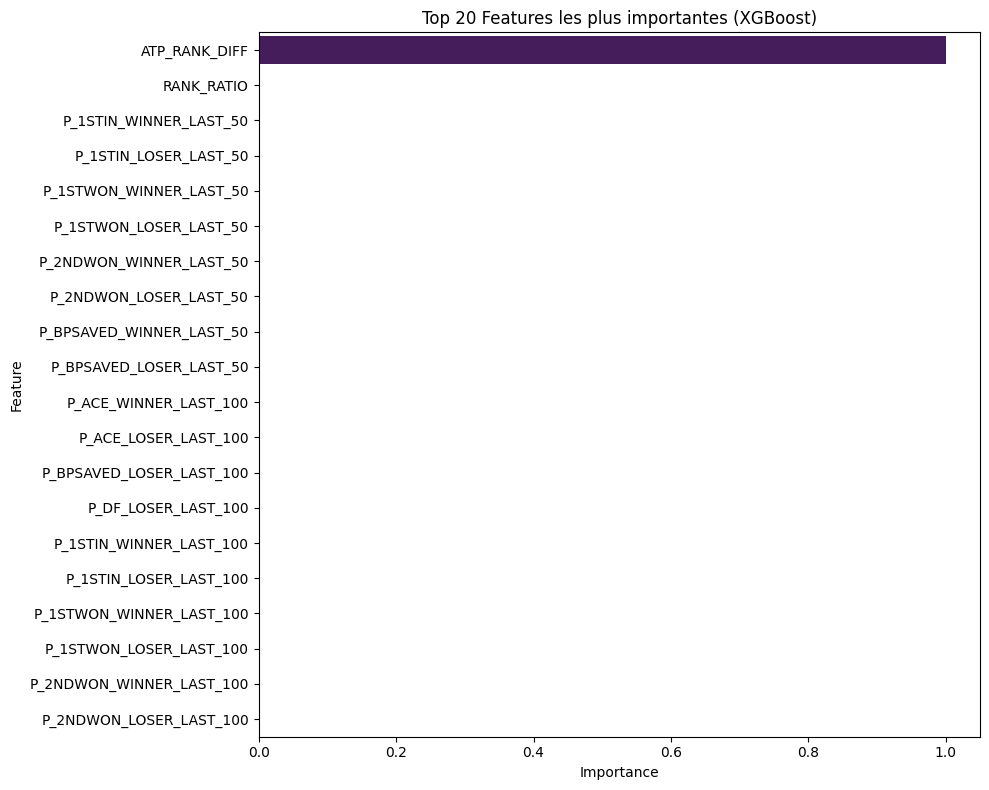

In [125]:
# Récupération des importances
importances = pd.Series(xgb_clf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False).head(20)

# Affichage
plt.figure(figsize=(10, 8))
sns.barplot(x=importances.values, y=importances.index, palette="viridis")
plt.title("Top 20 Features les plus importantes (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Grid Search CV pour XGBoost

In [126]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Paramètres à tester
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1]
}

# Modèle de base
xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1  # utilise tous les cœurs disponibles
)

# Entraînement
grid_search.fit(X_train, y_train)

# Résultats
print("Meilleurs paramètres trouvés :", grid_search.best_params_)
print("Meilleure accuracy (validation) :", grid_search.best_score_)

# Meilleur modèle
best_model = grid_search.best_estimator_

# Évaluation sur le test set
y_pred = best_model.predict(X_test)
print("Test Accuracy avec meilleurs params :", accuracy_score(y_test, y_pred))
print("\nClassification Report :\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/home/cytech/miniconda3/envs/TFM_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:56:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/cytech/miniconda3/envs/TFM_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:56:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/cytech/miniconda3/envs/TFM_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:56:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/cytech/miniconda3/envs/TFM_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:56:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/cytech/miniconda3/envs/TFM_env/lib/python3

Meilleurs paramètres trouvés : {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Meilleure accuracy (validation) : 1.0
Test Accuracy avec meilleurs params : 1.0

Classification Report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4678
           1       1.00      1.00      1.00      8465

    accuracy                           1.00     13143
   macro avg       1.00      1.00      1.00     13143
weighted avg       1.00      1.00      1.00     13143



_________

### Decision Tree with Sklearn

In [56]:
# Instantiate a Decision Tree
decision_sklearn = DecisionTreeClassifier(max_depth=4)
decision_sklearn = decision_sklearn.fit(data_np_train[:,:-1], y_pred_train)

# Make predictions and test accuracy
predictions_test = decision_sklearn.predict(data_np_test[:,:-1])
predictions_train = decision_sklearn.predict(data_np_train[:,:-1])
print("Train Accuracy: "+str(accuracy_score(y_pred_train, predictions_train)))
print("Test Accuracy: "+str(accuracy_score(y_pred_test, predictions_test)))

Train Accuracy: 0.8990312965722802
Test Accuracy: 0.8670886075949367


In [57]:
my_tree = DecisionTreeClassifier(max_depth=10)
my_tree = my_tree.fit(data_np_train[:,:-1], y_pred_train)

In [58]:
from sklearn import tree
text_representation = tree.export_text(decision_sklearn, feature_names=final_data.columns[2:-1])
print(text_representation)

|--- ELO_SURFACE_DIFF <= 0.50
|   |--- ELO_SURFACE_DIFF <= -9.91
|   |   |--- WIN_LAST_100_DIFF <= -0.01
|   |   |   |--- ELO_DIFF <= -29.18
|   |   |   |   |--- class: Player 2 Wins
|   |   |   |--- ELO_DIFF >  -29.18
|   |   |   |   |--- class: Player 2 Wins
|   |   |--- WIN_LAST_100_DIFF >  -0.01
|   |   |   |--- WIN_LAST_5_DIFF <= -0.50
|   |   |   |   |--- class: Player 1 Wins
|   |   |   |--- WIN_LAST_5_DIFF >  -0.50
|   |   |   |   |--- class: Player 2 Wins
|   |--- ELO_SURFACE_DIFF >  -9.91
|   |   |--- WIN_LAST_50_DIFF <= 0.02
|   |   |   |--- WIN_LAST_3_DIFF <= 0.17
|   |   |   |   |--- class: Player 1 Wins
|   |   |   |--- WIN_LAST_3_DIFF >  0.17
|   |   |   |   |--- class: Player 2 Wins
|   |   |--- WIN_LAST_50_DIFF >  0.02
|   |   |   |--- ELO_SURFACE_DIFF <= -6.85
|   |   |   |   |--- class: Player 2 Wins
|   |   |   |--- ELO_SURFACE_DIFF >  -6.85
|   |   |   |   |--- class: Player 2 Wins
|--- ELO_SURFACE_DIFF >  0.50
|   |--- ELO_SURFACE_DIFF <= 10.82
|   |   |--- WIN_LA

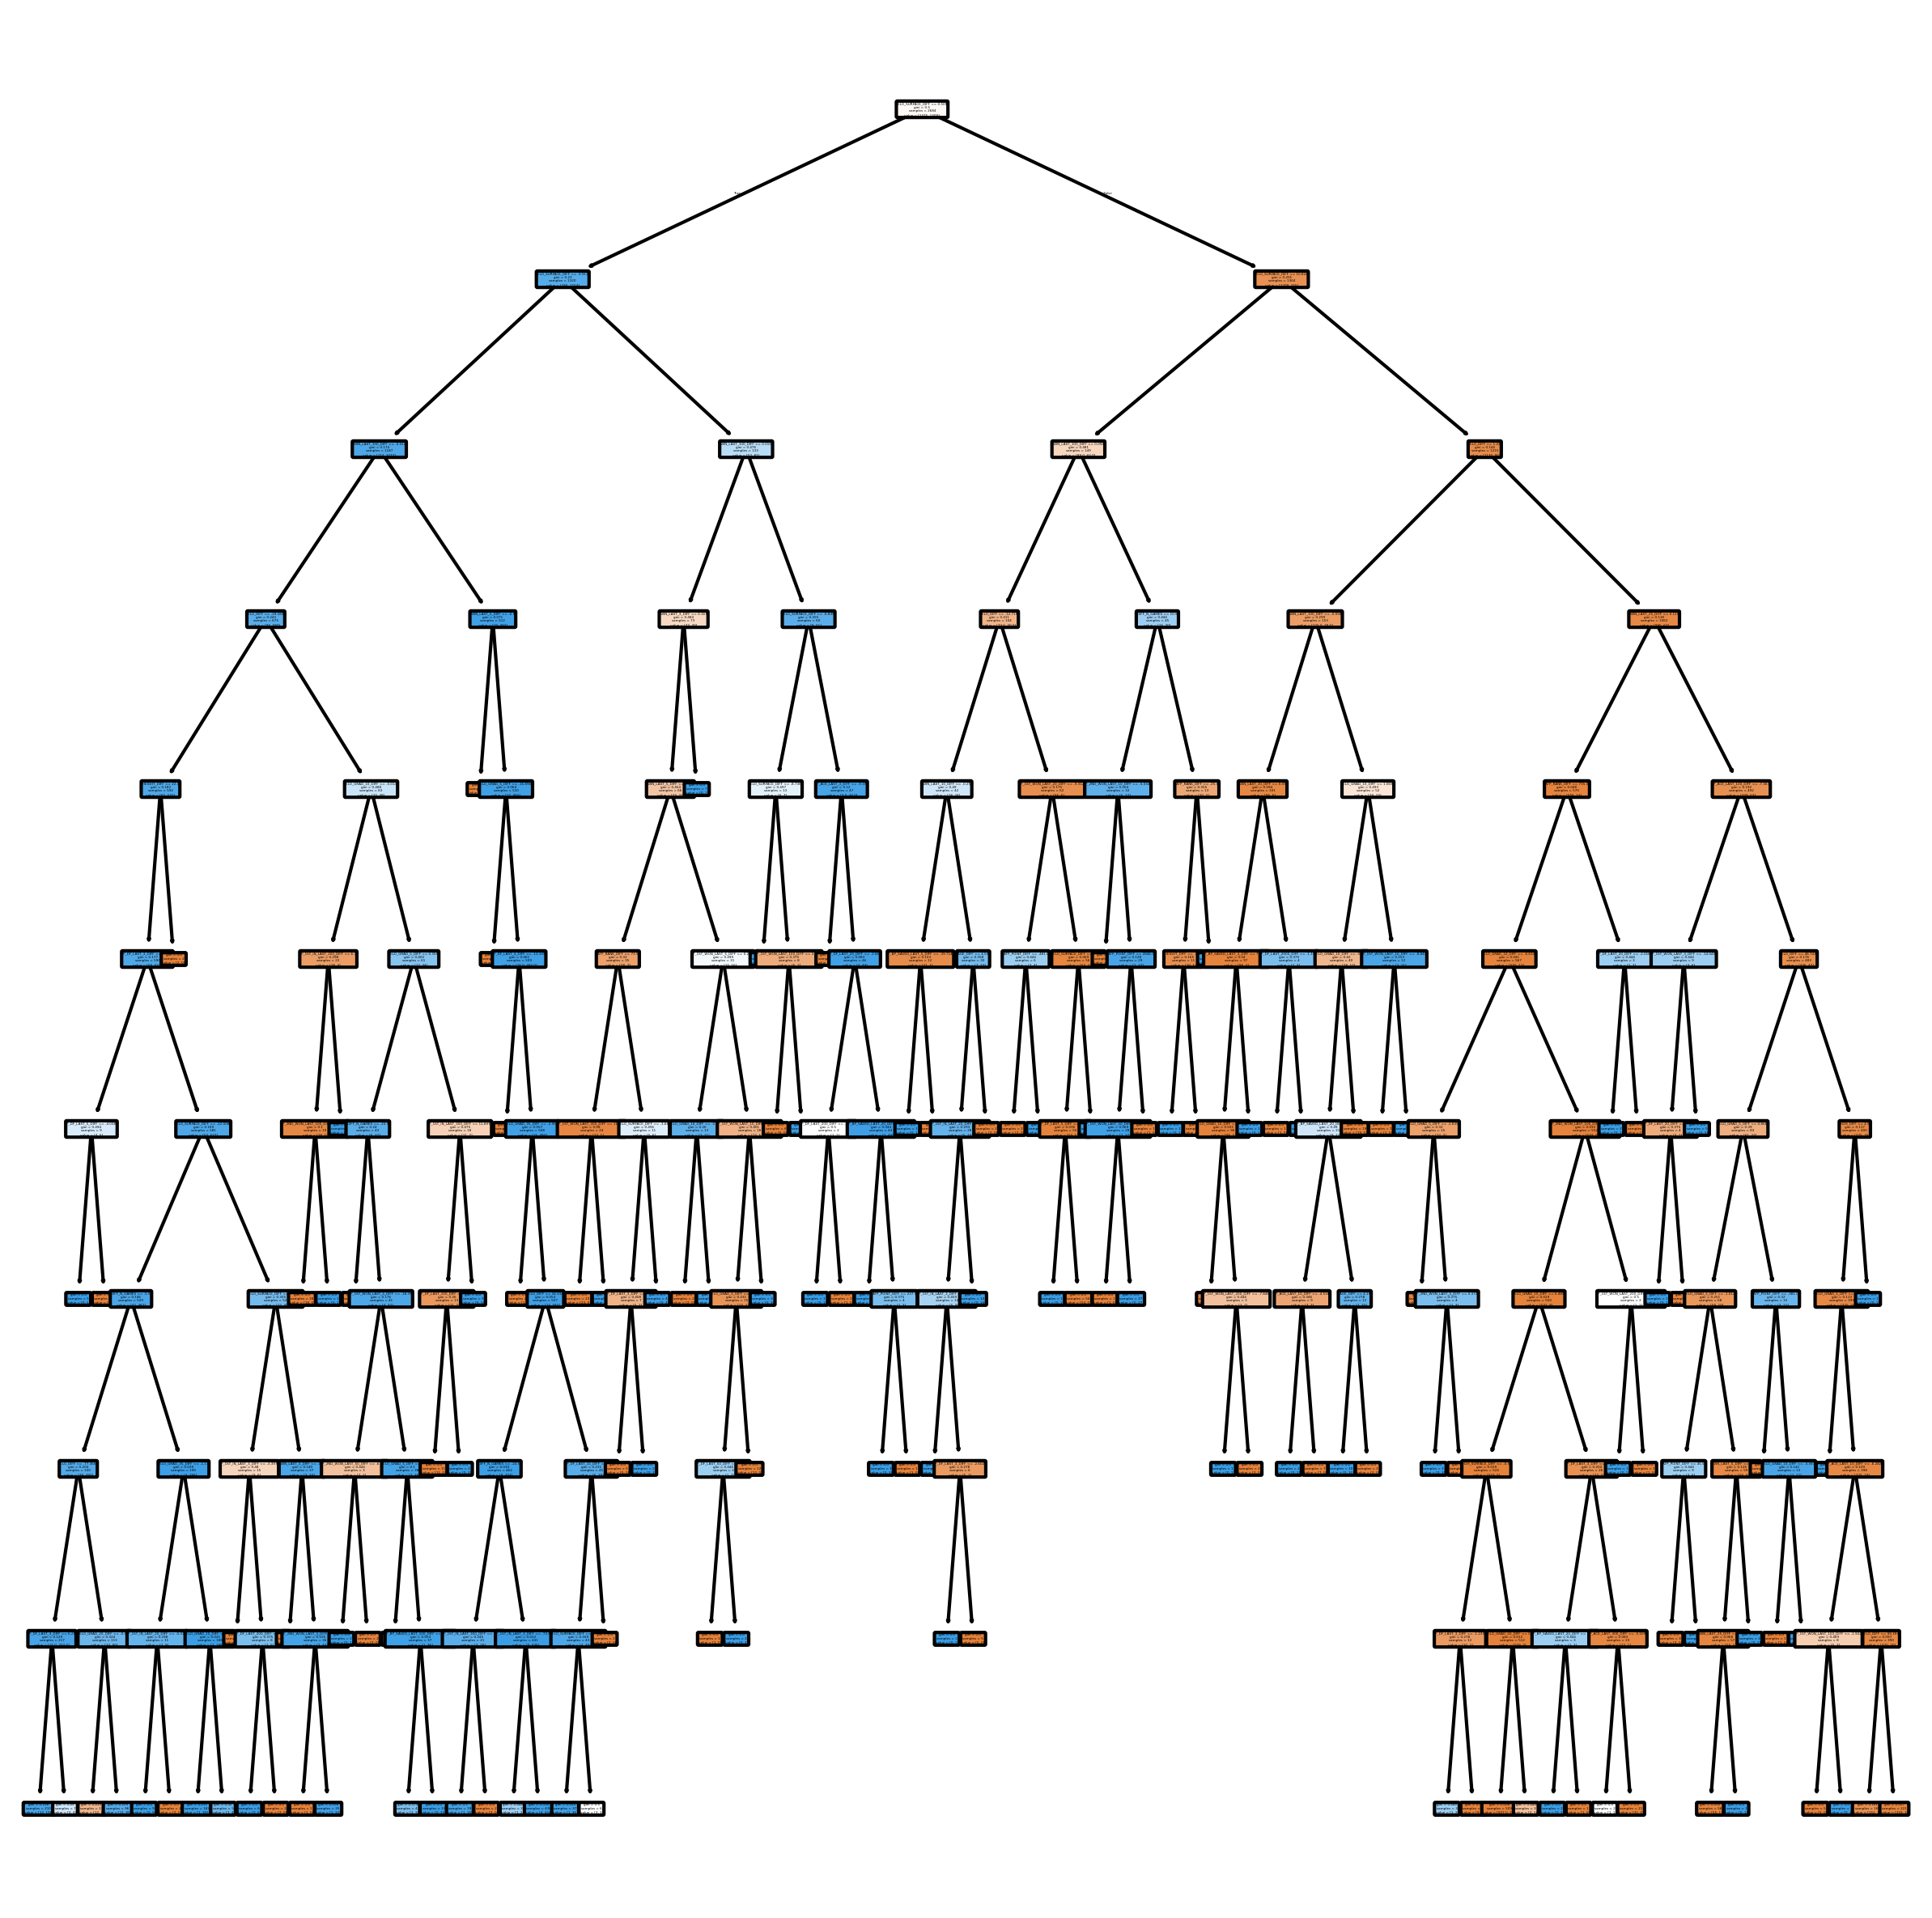

In [59]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
plot_tree(my_tree,filled=True,rounded=True, ax=axes, feature_names=final_data.columns[2:-1])
plt.savefig('./images/decision_tree_smaller_1.png', format='png', dpi=300)

### Random Forest with Sklearn

In [63]:
# Instantiate a RandomForest
forest_sklearn = RandomForestClassifier(n_estimators=500, max_depth=10, max_features="sqrt", bootstrap=True)
forest_sklearn = forest_sklearn.fit(x_train, y_pred_train)

# Make predictions and test accuracy
predictions_train = forest_sklearn.predict(x_train)
predictions_test = forest_sklearn.predict(x_test)
print("Train Accuracy: "+str(accuracy_score(y_pred_train, predictions_train)))
print("Test Accuracy: "+str(accuracy_score(y_pred_test, predictions_test)))

/home/cytech/miniconda3/envs/TFM_env/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train Accuracy: 0.9660953800298062
Test Accuracy: 0.8565400843881856


In [64]:
forest_sklearn.feature_importances_

array([0.0289667 , 0.02261338, 0.0075416 , 0.00652645, 0.00056463,
       0.00209161, 0.00164018, 0.00122154, 0.01801862, 0.00275834,
       0.00466098, 0.00951317, 0.01575916, 0.01334332, 0.0143284 ,
       0.0064122 , 0.00698523, 0.0063228 , 0.00687673, 0.00658178,
       0.00582583, 0.00634967, 0.00611537, 0.00535919, 0.00703867,
       0.0069607 , 0.00548509, 0.00531635, 0.00610371, 0.00588924,
       0.00998231, 0.00759817, 0.00559184, 0.00529397, 0.00529116,
       0.00540517, 0.00692859, 0.00764514, 0.00544409, 0.00551292,
       0.00537171, 0.00496113, 0.00589217, 0.0074827 , 0.00503441,
       0.00462422, 0.00552376, 0.00517782, 0.00553105, 0.00703088,
       0.00464608, 0.00524003, 0.00533509, 0.00529661, 0.00585653,
       0.00725782, 0.00497214, 0.00520338, 0.00518021, 0.0044954 ,
       0.00567174, 0.0066705 , 0.00478915, 0.00513282, 0.00516947,
       0.004692  , 0.00604303, 0.0077545 , 0.004847  , 0.17745598,
       0.32686778, 0.00884314, 0.00936979, 0.00542901, 0.00234

Okay, this is actually really overfitted (did not realize it was this much haha). Let's try some other parameters to see what happens

In [65]:
# Instantiate a RandomForest
forest_sklearn = RandomForestClassifier(n_estimators=200, max_depth=9, max_features="log2", bootstrap=True)
forest_sklearn = forest_sklearn.fit(data_np_train[:,:-1], y_pred_train)

# Make predictions and test accuracy
predictions_test = forest_sklearn.predict(data_np_test[:,:-1])
predictions_train = forest_sklearn.predict(data_np_train[:,:-1])
print("Train Accuracy: "+str(accuracy_score(y_pred_train, predictions_train)))
print("Test Accuracy: "+str(accuracy_score(y_pred_test, predictions_test)))

/home/cytech/miniconda3/envs/TFM_env/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train Accuracy: 0.9549180327868853
Test Accuracy: 0.8523206751054853


Okay, let me quickly visualize a smaller random forest

In [61]:
# test_random = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_split=400, min_samples_leaf=250, max_features="sqrt", bootstrap=True)
# test_random = test_random.fit(data_np_train[:5000,:-1], y_pred_train[:5000,:])

# fig, axes = plt.subplots(nrows=7, ncols=14, figsize=(16*1.5, 9*1.5), dpi=900)
# axes = axes.flatten()  # Convert to a 1D array for easier indexing

# num_estimators = min((7*14)-3, len(test_random.estimators_))  # Avoid out-of-bounds errors

# for index in range(num_estimators):
#     tree.plot_tree(test_random.estimators_[index],
#                    feature_names=final_data.columns[2:-1],
#                    filled=True,
#                    ax=axes[index])

#     axes[index].set_title(f'Estimator: {index}', fontsize=11)

# # Hide any unused subplots
# # for i in range(num_estimators, 100):
# #     fig.delaxes(axes[i])

# fig.tight_layout()
# fig.savefig('./images/random_forest/final_rf_100_max_depth.png')


# # fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=100)
# # for index in range(0, 5):
# #     tree.plot_tree(test_random.estimators_[index],
# #                    feature_names = final_data.columns[2:-1], 
# #                    filled = True,
# #                    ax = axes[index])

# #     axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
# # fig.savefig('rf_5trees.png')

![image info](./images/random_forest/final_rf_100_max_depth.png)

### XGBoost with Sklearn

In [66]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Instantiate an XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, subsample=0.8, colsample_bytree=0.7)

# Train the model
xgb_model.fit(data_np_train[:, :-1], reverse_mapper(y_pred_train))

# Make predictions
predictions_test = xgb_model.predict(data_np_test[:, :-1])
predictions_train = xgb_model.predict(data_np_train[:, :-1])

# Calculate accuracy
print("Train Accuracy: " + str(accuracy_score(reverse_mapper(y_pred_train), predictions_train)))
print("Test Accuracy: " + str(accuracy_score(reverse_mapper(y_pred_test), predictions_test)))


Train Accuracy: 1.0
Test Accuracy: 0.8734177215189873


In [67]:
# Sorting by importance in descending order
sorted_mapped_results = sorted(
    list(zip(final_data.columns[2:-1], list(xgb_model.feature_importances_))),
    key=lambda x: x[1], 
    reverse=True
)

# Extracting sorted labels and their importances
sorted_labels = [label for label, importance in sorted_mapped_results]
sorted_importances = [importance for _, importance in sorted_mapped_results]

# Displaying results
for label, importance in sorted_mapped_results:
    print(f"{label}: {importance:.4f}")


ELO_SURFACE_DIFF: 0.1957
ELO_DIFF: 0.0345
WIN_LAST_50_DIFF: 0.0254
P_ACE_LAST_300_DIFF: 0.0253
ELO_GRAD_50_DIFF: 0.0235
WIN_LAST_100_DIFF: 0.0204
P_2ND_WON_LAST_300_DIFF: 0.0192
P_2ND_WON_LAST_2000_DIFF: 0.0188
ELO_GRAD_35_DIFF: 0.0176
WIN_LAST_10_DIFF: 0.0169
WIN_LAST_5_DIFF: 0.0164
ELO_GRAD_20_DIFF: 0.0157
WIN_LAST_25_DIFF: 0.0156
ELO_GRAD_5_DIFF: 0.0152
ELO_GRAD_10_DIFF: 0.0144
P_2ND_WON_LAST_50_DIFF: 0.0135
P_1ST_WON_LAST_100_DIFF: 0.0129
WIN_LAST_3_DIFF: 0.0127
P_ACE_LAST_200_DIFF: 0.0125
H2H_SURFACE_DIFF: 0.0124
P_1ST_IN_LAST_200_DIFF: 0.0123
DIFF_N_GAMES: 0.0121
P_1ST_WON_LAST_5_DIFF: 0.0117
BEST_OF: 0.0113
P_1ST_WON_LAST_20_DIFF: 0.0112
ATP_RANK_DIFF: 0.0112
P_2ND_WON_LAST_20_DIFF: 0.0109
ATP_POINT_DIFF: 0.0108
HEIGHT_DIFF: 0.0106
P_DF_LAST_100_DIFF: 0.0105
P_1ST_IN_LAST_10_DIFF: 0.0105
P_1ST_WON_LAST_10_DIFF: 0.0103
P_ACE_LAST_10_DIFF: 0.0101
P_2ND_WON_LAST_3_DIFF: 0.0101
P_DF_LAST_10_DIFF: 0.0100
P_1ST_IN_LAST_3_DIFF: 0.0099
P_2ND_WON_LAST_10_DIFF: 0.0097
P_1ST_WON_LAST_2000_

### Basic Neural Net with Tensorflow

In [68]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(data_np_train[:, :-1])
X_test = scaler.transform(data_np_test[:, :-1])

# Define the neural network
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer
    layers.Dense(32, activation='relu'),  # Second hidden layer
    layers.Dense(16, activation='relu'),  # Third hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer (for binary classification)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, reverse_mapper(y_pred_train), epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate on test set
train_loss, train_acc = model.evaluate(X_train, reverse_mapper(y_pred_train), verbose=0)
test_loss, test_acc = model.evaluate(X_test, reverse_mapper(y_pred_test), verbose=0)

print(f"Train Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")


2025-03-19 12:01:06.412751: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 12:01:06.562297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742382066.629393    5947 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742382066.648322    5947 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 12:01:06.783685: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Epoch 1/50


/home/cytech/miniconda3/envs/TFM_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-19 12:01:09.204792: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6047 - loss: 0.6709 - val_accuracy: 0.7356 - val_loss: 0.5698
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7744 - loss: 0.5185 - val_accuracy: 0.7952 - val_loss: 0.4744
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8416 - loss: 0.3946 - val_accuracy: 0.8361 - val_loss: 0.4327
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8981 - loss: 0.2985 - val_accuracy: 0.8566 - val_loss: 0.4133
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9074 - loss: 0.2602 - val_accuracy: 0.8380 - val_loss: 0.4128
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8965 - loss: 0.2757 - val_accuracy: 0.8585 - val_loss: 0.4087
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9122 - loss: 0.2536 - val_accuracy: 0.8529 - val_loss: 0.4243
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9225 - loss: 0.2330 - val_accuracy: 0.8473 - val_loss: 0.4121
Epo

## GridSearch CV

Trying GridSearchCV to see what happens

In [69]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

# Instantiate an XGBoost Classifier
xgb_model = XGBClassifier()

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=3, n_jobs=-1)
grid_search.fit(data_np_train[:, :-1], reverse_mapper(y_pred_train))

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train the best model
best_xgb_model = grid_search.best_estimator_

# Make predictions
predictions_test = best_xgb_model.predict(data_np_test[:, :-1])
predictions_train = best_xgb_model.predict(data_np_train[:, :-1])

# Calculate accuracy
print("Train Accuracy:", accuracy_score(reverse_mapper(y_pred_train), predictions_train))
print("Test Accuracy:", accuracy_score(reverse_mapper(y_pred_test), predictions_test))


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.6;, score=0.890 total time=   2.8s
[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.6;, score=0.914 total time=   2.6s
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.6;, score=0.907 total time=   2.7s
[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8;, score=0.896 total time=   2.7s
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.6;, score=0.869 total time=   3.2s
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8;, score=0.911 total time=   3.1s
[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.6;, score=0.901 total time=   3.3s
[CV 2

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,
    verbose=4
)
grid_search.fit(data_np_train[:,:-1], y_pred_train.squeeze())

print("Best params:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


## Predict Australian Open 2025

In [71]:
# Australian Open Data
aus_data_np = final_data.to_numpy(dtype=object)[95375:, 2:]
full_aus_data_np = final_data.iloc[95375:, :]

x_test_aus = aus_data_np[:,:-1]
y_pred_test_aus = mapper(aus_data_np[:,-1:])

ValueError: cannot call `vectorize` on size 0 inputs unless `otypes` is set

In [72]:
# Make predictions
predictions_test = xgb_model.predict(aus_data_np[:, :-1])

# Calculate accuracy
print("Accuracy: " + str(accuracy_score(reverse_mapper(y_pred_test_aus), predictions_test)))


NotFittedError: need to call fit or load_model beforehand

In [67]:
full_aus_data_np["PREDICTION"] = list(predictions_test)
full_aus_data_np

/var/folders/2n/3gvc3mg10j76nnrf7fqlxh640000gn/T/ipykernel_10163/4142515727.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_aus_data_np["PREDICTION"] = list(predictions_test)


PLAYER_1  PLAYER_2  ATP_POINT_DIFF  ATP_RANK_DIFF   AGE_DIFF  \
0    200384.0  117357.0           380.0          -98.0  -3.358658   
1    202261.0  209950.0         -1653.0           72.0   2.975359   
2    106329.0  105453.0          -177.0           29.0  -4.419576   
3    134770.0  144719.0          3288.0          -56.0  -1.632444   
4    200273.0  207352.0          -520.0          152.0   3.413415   
..        ...       ...             ...            ...        ...   
111  104925.0  207989.0         -3110.0            4.0  15.953457   
112  210097.0  132283.0          1254.0          -35.0  -7.413415   
113  200282.0  206173.0         -8295.0            7.0   2.493498   
114  206173.0  210097.0          9550.0          -19.0   1.147844   
115  206173.0  100644.0          4195.0           -1.0  -4.323066   

     HEIGHT_DIFF  BEST_OF  DRAW_SIZE  H2H_DIFF  H2H_SURFACE_DIFF  \
0          -10.0        5        128       0.0               0.0   
1            8.0        5        128      -0.0              -0.0   
2            5.0        5        128      -1.0              -0.0   
3            0.0        5        128       1.0              -1.0   
4            3.0        5        128       0.0               0.0   
..           ...      ...        ...       ...               ...   
111          5.0        5        128       1.0               2.0   
112          2.0        5        128       0.0               1.0   
113         -8.0        5        128      -9.0              -8.0   
114         -2.0        5        128       3.0               2.0   
115         -7.0        5        128      -2.0              -2.0   

     DIFF_N_GAMES  WIN_LAST_3_DIFF  WIN_LAST_5_DIFF  WIN_LAST_10_DIFF  \
0            91.0         0.666667              0.6          0.200000   
1           -83.0        -0.000000              0.2         -0.100000   
2          -422.0         0.333333             -0.0         -0.200000   
3           159.0         0.666667              0.4          0.300000   
4           -10.0        -0.666667             -0.2         -0.028571   
..            ...              ...              ...               ...   
111        1033.0         0.000000              0.0          0.100000   
112        -171.0         0.000000             -0.2          0.200000   
113          56.0        -0.000000             -0.2         -0.500000   
114         218.0         0.000000              0.2          0.200000   
115        -304.0         0.000000              0.0          0.100000   

     WIN_LAST_25_DIFF  WIN_LAST_50_DIFF  WIN_LAST_100_DIFF  P_ACE_LAST_3_DIFF  \
0            0.280000          0.180000           0.216667           2.340095   
1           -0.143333         -0.163333          -0.153333           1.021036   
2            0.080000         -0.140000          -0.120000           8.859508   
3            0.160000          0.260000           0.230000           7.608016   
4           -0.016807         -0.016807          -0.016807          -1.028781   
..                ...               ...                ...                ...   
111          0.120000         -0.040000           0.050000          -5.606295   
112          0.160000          0.140000           0.130000          -3.408474   
113         -0.320000         -0.260000          -0.220000          -1.931250   
114          0.240000          0.320000           0.300000           3.856558   
115          0.160000          0.140000           0.150000          -1.601140   

     P_DF_LAST_3_DIFF  P_1ST_IN_LAST_3_DIFF  P_1ST_WON_LAST_3_DIFF  \
0           -1.467278             -7.286214               9.921019   
1            1.331668              0.338129              -9.683379   
2            2.031115             -2.699578              -1.816997   
3           -4.254308              2.699290              18.460926   
4            3.671474              4.062651             -19.514842   
..                ...                   ...                    ...   
111          1.6621

In [68]:
# Jannik Sinner's Run in the Australian Open
full_aus_data_np[(full_aus_data_np["PLAYER_1"] == 206173.0) | (full_aus_data_np["PLAYER_2"] == 206173.0)]

PLAYER_1  PLAYER_2  ATP_POINT_DIFF  ATP_RANK_DIFF  AGE_DIFF  HEIGHT_DIFF  \
19   111797.0  206173.0        -10490.0           35.0  5.846680         10.0   
87   209262.0  206173.0        -11494.0          172.0  0.468857         -8.0   
102  206173.0  106218.0         10655.0          -45.0 -8.062971         11.0   
107  206173.0  208029.0          8920.0          -12.0  1.701574          3.0   
113  200282.0  206173.0         -8295.0            7.0  2.493498         -8.0   
114  206173.0  210097.0          9550.0          -19.0  1.147844         -2.0   
115  206173.0  100644.0          4195.0           -1.0 -4.323066         -7.0   

     BEST_OF  DRAW_SIZE  H2H_DIFF  H2H_SURFACE_DIFF  DIFF_N_GAMES  \
19         5        128      -0.0              -1.0        -122.0   
87         5        128      -0.0              -0.0        -335.0   
102        5        128       1.0               1.0         120.0   
107        5        128       0.0               0.0         123.0   
113        5        128      -9.0              -8.0          56.0   
114        5        128       3.0               2.0         218.0   
115        5        128      -2.0              -2.0        -304.0   

     WIN_LAST_3_DIFF  WIN_LAST_5_DIFF  WIN_LAST_10_DIFF  WIN_LAST_25_DIFF  \
19         -0.333333             -0.6         -0.600000         -0.600000   
87         -0.333333             -0.6         -0.666667         -0.626667   
102         0.000000              0.2          0.300000          0.360000   
107         0.000000              0.0          0.100000          0.200000   
113        -0.000000             -0.2         -0.500000         -0.320000   
114         0.000000              0.2          0.200000          0.240000   
115         0.000000              0.0          0.100000          0.160000   

     WIN_LAST_50_DIFF  WIN_LAST_100_DIFF  P_ACE_LAST_3_DIFF  P_DF_LAST_3_DIFF  \
19          -0.460000          -0.350000          -0.767449         -0.385235   
87          -0.586667          -0.586667          -2.491025          2.588557   
102          0.400000           0.430000           9.065229         -1.420019   
107          0.240000           0.280000           4.222852         -2.206778   
113         -0.260000          -0.220000          -1.931250          2.011506   
114          0.320000           0.300000           3.856558         -0.212808   
115          0.140000           0.150000          -1.601140          0.682342   

     P_1ST_IN_LAST_3_DIFF  P_1ST_WON_LAST_3_DIFF  P_2ND_WON_LAST_3_DIFF  \
19              -6.206405               3.241149              13.674634   
87              -5.241077              -1.821772             -10.243607   
102              5.076761               7.454602              10.515836   
107             -0.719233               1.725510              -2.861324   
113             -7.557611              -2.142773              -9.788109   
114            -12.774315               1.454393              -5.388693   
115            -11.308906              -2.789013             -15.579806   

     P_BP_SAVED_LAST_3_DIFF  P_ACE_LAST_5_DIFF  P_DF_LAST_5_DIFF  \
19                -1.269841           0.073395          0.995846   
87                -4.856255          -3.211857          3.840723   
102               -2.698413           7.144151         -1.206500   
107              -27.777778           4.067774         -1.679122   
113               -0.000000          -4.828748          1.848594   
114               -2.020202           1.854746          0.006506   
115              -38.888889          -0.746477         -0.215111   

     P_1ST_IN_LAST_5_DIFF  P_1ST_WON_LAST_5_DIFF  P_2ND_WON_LAST_5_DIFF  \
19              -4.621047               0.619672              -1.441189   
87              -5.305339              -1.616567             -14.351247   
102              3.727316               2.852016              15.972634   
107             -1.152133               2.460026               5.429175   
113             

In [69]:
# Carlos Alcaraz's Run in the Australian Open
full_aus_data_np[(full_aus_data_np["PLAYER_1"] == 207989.0) | (full_aus_data_np["PLAYER_2"] == 207989.0)]

PLAYER_1  PLAYER_2  ATP_POINT_DIFF  ATP_RANK_DIFF   AGE_DIFF  \
30   207686.0  207989.0         -6267.0           74.0   2.430527   
60   207989.0  106415.0          6203.0          -62.0  -7.603012   
90   132686.0  207989.0         -5565.0           30.0   6.206023   
111  104925.0  207989.0         -3110.0            4.0  15.953457   

     HEIGHT_DIFF  BEST_OF  DRAW_SIZE  H2H_DIFF  H2H_SURFACE_DIFF  \
30           2.0        5        128      -1.0              -0.0   
60          13.0        5        128       1.0               1.0   
90           2.0        5        128      -1.0              -0.0   
111          5.0        5        128       1.0               2.0   

     DIFF_N_GAMES  WIN_LAST_3_DIFF  WIN_LAST_5_DIFF  WIN_LAST_10_DIFF  \
30         -179.0        -0.333333             -0.2              -0.2   
60          -15.0         0.000000              0.2               0.1   
90         -178.0        -0.333333             -0.6              -0.2   
111        1033.0         0.000000              0.0               0.1   

     WIN_LAST_25_DIFF  WIN_LAST_50_DIFF  WIN_LAST_100_DIFF  P_ACE_LAST_3_DIFF  \
30              -0.28             -0.36          -0.349524          -4.766166   
60               0.12              0.30           0.270000          11.397165   
90              -0.20             -0.30          -0.353218          -9.148824   
111              0.12             -0.04           0.050000          -5.606295   

     P_DF_LAST_3_DIFF  P_1ST_IN_LAST_3_DIFF  P_1ST_WON_LAST_3_DIFF  \
30           0.671846              1.937489             -13.686440   
60           0.587222            -10.208747              22.041097   
90           0.800235             11.013557             -23.374599   
111          1.662195              6.493292              -4.925324   

     P_2ND_WON_LAST_3_DIFF  P_BP_SAVED_LAST_3_DIFF  P_ACE_LAST_5_DIFF  \
30              -13.400673               22.222222          -5.343051   
60               12.368126              -19.444444          10.903123   
90              -27.970885               11.481481          -7.585254   
111              -4.204545               20.000000          -4.677414   

     P_DF_LAST_5_DIFF  P_1ST_IN_LAST_5_DIFF  P_1ST_WON_LAST_5_DIFF  \
30          -0.414339             -0.157390              -6.226280   
60           0.425038             -4.524627              17.389874   
90           1.912320             -1.605430             -19.089602   
111         -0.620253              3.513337               0.640947   

     P_2ND_WON_LAST_5_DIFF  P_BP_SAVED_LAST_5_DIFF  P_ACE_LAST_10_DIFF  \
30               -9.684514               25.833333           -2.888275   
60               11.023215              -19.166667            8.734307   
90              -24.449427               11.388889           -4.796414   
111              -2.106687               24.500000           -4.329239   

     P_DF_LAST_10_DIFF  P_1ST_IN_LAST_10_DIFF  P_1ST_WON_LAST_10_DIFF  \
30            1.379713              -1.296527               -5.900796   
60            0.566758              -2.236425               14.369960   
90            2.895807              -2.621103              -11.233085   
111           2.276022               0.048940               -0.483814   

     P_2ND_WON_LAST_10_DIFF  P_BP_SAVED_LAST_10_DIFF  P_ACE_LAST_20_DIFF  \
30                -4.021563                 0.037879           -1.531503   
60                 0.939580                 2.719697            4.607440   
90               -12.719642                -5.305556           -3.020299   
111               -1.380846                10.166667           -0.184295   

     P_DF_LAST_20_DIFF  P_1ST_IN_LAST_20_DIFF  P_1ST_WON_LAST_20_DIFF  \
30            1.817468              -2.842227               -8.933070   
60            0.449391              -1.084935               10.220508   
90            2.302572              -1.010454              -10.164326   
111           1.556406               0.503063               -0.21049

In [70]:
# Wrong Results
full_aus_data_np[((full_aus_data_np["RESULT"] == -1.0) & (full_aus_data_np["PREDICTION"] == 1)) 
                 | ((full_aus_data_np["RESULT"] == 1.0) & (full_aus_data_np["PREDICTION"] == 0))]

PLAYER_1  PLAYER_2  ATP_POINT_DIFF  ATP_RANK_DIFF   AGE_DIFF  \
0    200384.0  117357.0           380.0          -98.0  -3.358658   
4    200273.0  207352.0          -520.0          152.0   3.413415   
14   210506.0  126774.0         -1925.0           30.0  -6.035592   
17   105902.0  208502.0           464.0         -215.0  10.567420   
43   128034.0  134868.0          1275.0          -23.0  -0.613279   
44   207680.0  200267.0          -190.0           13.0  -1.533881   
47   208286.0  207518.0         -1295.0           24.0   1.024641   
51   106283.0  208014.0          -363.0           74.0   7.114990   
52   207925.0  144869.0           197.0           -6.0  -2.800137   
58   211663.0  126094.0         -3000.0          103.0  -8.835729   
66   126846.0  200624.0         -1287.0           46.0   4.246407   
67   207985.0  209070.0          -100.0           14.0   1.106776   
73   126205.0  105453.0          2452.0          -65.0  -7.381246   
85   211663.0  132283.0          -506.0           57.0 -11.279261   
88   106421.0  210530.0          4537.0         -116.0   9.805613   
97   126203.0  104792.0          4070.0          -37.0 -11.156057   
99   206681.0  132283.0           -66.0            4.0  -4.410678   
104  126205.0  200221.0          2405.0          -55.0   2.052019   

     HEIGHT_DIFF  BEST_OF  DRAW_SIZE  H2H_DIFF  H2H_SURFACE_DIFF  \
0          -10.0        5        128       0.0               0.0   
4            3.0        5        128       0.0               0.0   
14           0.0        5        128       1.0               1.0   
17           0.0        5        128       0.0               0.0   
43           8.0        5        128       0.0               0.0   
44          -2.0        5        128      -1.0              -1.0   
47          -0.0        5        128      -2.0              -0.0   
51          10.0        5        128       0.0               0.0   
52         -13.0        5        128      -0.0              -0.0   
58          -3.0        5        128       0.0               0.0   
66          -8.0        5        128       1.0               1.0   
67           0.0        5        128       0.0               0.0   
73           7.0        5        128      -1.0              -1.0   
85          -6.0        5        128       1.0              -0.0   
88          18.0        5        128      -0.0              -0.0   
97           3.0        5        128       1.0               1.0   
99           2.0        5        128      -0.0              -0.0   
104          2.0        5        128       3.0               3.0   

     DIFF_N_GAMES  WIN_LAST_3_DIFF  WIN_LAST_5_DIFF  WIN_LAST_10_DIFF  \
0            91.0         0.666667              0.6          0.200000   
4           -10.0        -0.666667             -0.2         -0.028571   
14         -417.0         0.000000              0.0          0.000000   
17          123.0        -0.666667             -0.6         -0.300000   
43          164.0         0.000000             -0.2          0.100000   
44          -14.0        -1.000000             -0.6         -0.300000   
47         -145.0        -0.000000             -0.0         -0.100000   
51          -31.0         0.000000              0.0         -0.100000   
52          -57.0        -0.000000             -0.0         -0.000000   
58         -490.0         0.666667              0.6          0.400000   
66         -110.0         0.333333              0.2          0.000000   
67          -25.0        -0.333333             -0.2         -0.100000   
73         -343.0        -0.333333              0.0          0.100000   
85         -273.0        -0.000000              0.4          0.500000   
88          514.0        -0.000000             -0.4         -0.100000   
97         -419.0        -0.000000             -0.0         -0.000000   
99         -224.0        -0.333333              0.2          0.100000   
104          66.0         0.333333              0.0          0.300000   

     WIN_LAS

In [71]:
# Correct Results
full_aus_data_np[((full_aus_data_np["RESULT"] == 1.0) & (full_aus_data_np["PREDICTION"] == 1)) 
                 | ((full_aus_data_np["RESULT"] == -1.0) & (full_aus_data_np["PREDICTION"] == 0))]

PLAYER_1  PLAYER_2  ATP_POINT_DIFF  ATP_RANK_DIFF   AGE_DIFF  \
1    202261.0  209950.0         -1653.0           72.0   2.975359   
2    106329.0  105453.0          -177.0           29.0  -4.419576   
3    134770.0  144719.0          3288.0          -56.0  -1.632444   
5    111454.0  208103.0         -1318.0          139.0   5.451745   
6    111576.0  207830.0         -1170.0           66.0   3.158795   
..        ...       ...             ...            ...        ...   
111  104925.0  207989.0         -3110.0            4.0  15.953457   
112  210097.0  132283.0          1254.0          -35.0  -7.413415   
113  200282.0  206173.0         -8295.0            7.0   2.493498   
114  206173.0  210097.0          9550.0          -19.0   1.147844   
115  206173.0  100644.0          4195.0           -1.0  -4.323066   

     HEIGHT_DIFF  BEST_OF  DRAW_SIZE  H2H_DIFF  H2H_SURFACE_DIFF  \
1            8.0        5        128      -0.0              -0.0   
2            5.0        5        128      -1.0              -0.0   
3            0.0        5        128       1.0              -1.0   
5           -2.0        5        128      -0.0              -0.0   
6           -5.0        5        128      -0.0              -0.0   
..           ...      ...        ...       ...               ...   
111          5.0        5        128       1.0               2.0   
112          2.0        5        128       0.0               1.0   
113         -8.0        5        128      -9.0              -8.0   
114         -2.0        5        128       3.0               2.0   
115         -7.0        5        128      -2.0              -2.0   

     DIFF_N_GAMES  WIN_LAST_3_DIFF  WIN_LAST_5_DIFF  WIN_LAST_10_DIFF  \
1           -83.0        -0.000000              0.2            -0.100   
2          -422.0         0.333333             -0.0            -0.200   
3           159.0         0.666667              0.4             0.300   
5          -129.0        -0.333333             -0.4            -0.375   
6           -45.0        -0.000000             -0.4            -0.300   
..            ...              ...              ...               ...   
111        1033.0         0.000000              0.0             0.100   
112        -171.0         0.000000             -0.2             0.200   
113          56.0        -0.000000             -0.2            -0.500   
114         218.0         0.000000              0.2             0.200   
115        -304.0         0.000000              0.0             0.100   

     WIN_LAST_25_DIFF  WIN_LAST_50_DIFF  WIN_LAST_100_DIFF  P_ACE_LAST_3_DIFF  \
1           -0.143333         -0.163333          -0.153333           1.021036   
2            0.080000         -0.140000          -0.120000           8.859508   
3            0.160000          0.260000           0.230000           7.608016   
5           -0.475000         -0.475000          -0.445000          -9.311441   
6           -0.360000         -0.400000          -0.341176          -6.955410   
..                ...               ...                ...                ...   
111          0.120000         -0.040000           0.050000          -5.606295   
112          0.160000          0.140000           0.130000          -3.408474   
113         -0.320000         -0.260000          -0.220000          -1.931250   
114          0.240000          0.320000           0.300000           3.856558   
115          0.160000          0.140000           0.150000          -1.601140   

     P_DF_LAST_3_DIFF  P_1ST_IN_LAST_3_DIFF  P_1ST_WON_LAST_3_DIFF  \
1            1.331668              0.338129              -9.683379   
2            2.031115             -2.699578              -1.816997   
3           -4.254308              2.699290              18.460926   
5            1.460735             -1.759381             -17.850856   
6           -0.012349              7.763318              -2.992454   
..                ...                   ...                    ...   
111          1.6621